<a href="https://colab.research.google.com/github/sargyri/Drop_Lev/blob/master/Machine_learning/test_training_ST_on_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Lev Droplet 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/basic_regression"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/r2.0rc/site/en/tutorials/keras/basic_regression.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

Training NN model(s) on theoretical data generated via the simple physical model

In [1]:
!pip install lmfit
!pip install importlib-metadata
#!pip install seaborn

     |████████████████████████████████| 307kB 5.2MB/s 
     |████████████████████████████████| 256kB 9.2MB/s 
  Created wheel for lmfit: filename=lmfit-1.0.2-cp37-none-any.whl size=85278 sha256=9f5be43aedc9626c0de6679bcc35969da5ac8b1016486498aaed403017251d53
  Stored in directory: /root/.cache/pip/wheels/d4/5e/db/d9f5987d9f15bf910feb5e0274ac601d5f2161dc78aedfacfa
  Created wheel for asteval: filename=asteval-0.9.25-cp37-none-any.whl size=17301 sha256=57974f6dd0f41b80691751c43c2be6e70260260fbd463f4adda6badba89aca46
  Stored in directory: /root/.cache/pip/wheels/75/4e/83/fb48cc07d800283881ee75940ac6d7bae561305b3545e07785
Successfully built lmfit asteval


In [3]:
# import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd
import numpy as np 

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """
    if phi<=np.pi/2:
        theta=np.pi/2-phi
    else:
        theta=2.5*np.pi-phi
    return theta


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

2.5.0
Num GPUs Available:  0


Check the connection to google's **GPU**

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### Generate data based on experimental data

Run the next code box only if google drive is not mounted to colab

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [212]:
#From the drive folder that is mounted to collab go to the file that you are interested in, 
#right click and copy the path of the file. Paste it in csvfilename:
path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/')

# fileSDS1=pd.read_csv(str(path+'SDS/SDS_conci_0.01054_all.csv'), sep="\t", header=None)
# fileSDS2=pd.read_csv(str(path+'SDS/SDS_conci_0.02108_all.csv'), sep='\t', header=None)
# fileSDS3=pd.read_csv(str(path+'SDS/SDS_conci_0.04273_all.csv'), sep='\t', header=None)
# fileSDS4=pd.read_csv(str(path+'SDS/SDS_conci_0.08828_all.csv'), sep="\t", header=None)
# fileSDS5=pd.read_csv(str(path+'SDS/SDS_conci_0.25000_all.csv'), sep="\t", header=None)
# fileSDS6=pd.read_csv(str(path+'SDS/SDS_conci_0.50000_all.csv'), sep="\t", header=None)
# fileSDS7=pd.read_csv(str(path+'SDS/SDS_conci_0.75000_all.csv'), sep="\t", header=None)
# fileSDS8=pd.read_csv(str(path+'SDS/SDS_conci_1.00000_all.csv'), sep="\t", header=None)
# fileSDS9=pd.read_csv(str(path+'SDS/SDS_conci_1.25000_all.csv'), sep="\t", header=None)
# fileSDS10=pd.read_csv(str(path+'SDS/SDS_conci_1.50000_all.csv'), sep="\t", header=None)
# fileSDS11=pd.read_csv(str(path+'SDS/SDS_conci_2.00000_all.csv'), sep="\t", header=None)
# fileSDS12=pd.read_csv(str(path+'SDS/SDS_conci_2.50000_all.csv'), sep="\t", header=None)
# fileSDS13=pd.read_csv(str(path+'SDS/SDS_conci_3.00000_all.csv'), sep="\t", header=None)
# fileSDS14=pd.read_csv(str(path+'SDS/SDS_conci_3.50000_all.csv'), sep="\t", header=None)
# fileSDS15=pd.read_csv(str(path+'SDS/SDS_conci_4.00000_all.csv'), sep="\t", header=None)
# fileSDS16=pd.read_csv(str(path+'SDS/SDS_conci_4.50000_all.csv'), sep="\t", header=None)
# fileSDS17=pd.read_csv(str(path+'SDS/SDS_conci_5.50000_all.csv'), sep="\t", header=None)
# fileSDS18=pd.read_csv(str(path+'SDS/SDS_conci_6.50000_all.csv'), sep="\t", header=None)
# fileSDS19=pd.read_csv(str(path+'SDS/SDS_conci_7.50000_all.csv'), sep="\t", header=None)
# fileSDS20=pd.read_csv(str(path+'SDS/SDS_conci_8.50000_all.csv'), sep="\t", header=None)
# fileSDS21=pd.read_csv(str(path+'SDS/SDS_conci_24.75900_all.csv'), sep="\t", header=None)

# fileTrit1=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00250_all.csv'), sep="\t", header=None)
# fileTrit2=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00500_all.csv'), sep="\t", header=None)
# fileTrit3=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.00750_all.csv'), sep="\t", header=None)
# fileTrit4=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01000_all.csv'), sep="\t", header=None)
# fileTrit5=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.01500_all.csv'), sep="\t", header=None)
# fileTrit6=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02000_all.csv'), sep="\t", header=None)
# fileTrit7=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.02500_all.csv'), sep="\t", header=None)
# fileTrit8=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.03500_all.csv'), sep="\t", header=None)
# fileTrit9=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.05000_all.csv'), sep="\t", header=None)
# fileTrit10=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.07500_all.csv'), sep="\t", header=None)
# fileTrit11=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.10000_all.csv'), sep="\t", header=None)
# fileTrit12=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.12500_all.csv'), sep="\t", header=None)
# fileTrit13=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.15000_all.csv'), sep="\t", header=None)
# fileTrit14=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.17500_all.csv'), sep="\t", header=None)
# fileTrit15=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.20000_all.csv'), sep="\t", header=None)
# fileTrit16=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.25000_all.csv'), sep="\t", header=None)
# fileTrit17=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.30000_all.csv'), sep="\t", header=None)
# fileTrit18=pd.read_csv(str(path+'TritonX100/TritonX_conci_0.45000_all.csv'), sep="\t", header=None)
# fileTrit19=pd.read_csv(str(path+'TritonX100/TritonX_conci_1.00000_all.csv'), sep="\t", header=None)
# fileTrit20=pd.read_csv(str(path+'TritonX100/TritonX_conci_3.00000_all.csv'), sep="\t", header=None)
# fileTrit21=pd.read_csv(str(path+'TritonX100/TritonX_conci_10.00000_all.csv'), sep="\t", header=None)

# fileCTAB1=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00100_all.csv'), sep="\t", header=None)
# fileCTAB2=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00200_all.csv'), sep="\t", header=None)
# fileCTAB3=pd.read_csv(str(path+'CTAB/CTAB_conci_0.00500_all.csv'), sep="\t", header=None)
# fileCTAB4=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01000_all.csv'), sep="\t", header=None)
# fileCTAB5=pd.read_csv(str(path+'CTAB/CTAB_conci_0.01500_all.csv'), sep="\t", header=None)
# fileCTAB6=pd.read_csv(str(path+'CTAB/CTAB_conci_0.05500_all.csv'), sep="\t", header=None)
fileCTAB7=pd.read_csv(str(path+'CTAB/CTAB_conci_0.10000_all.csv'), sep="\t", header=None)
fileCTAB8=pd.read_csv(str(path+'CTAB/CTAB_conci_0.15000_all.csv'), sep="\t", header=None)
fileCTAB9=pd.read_csv(str(path+'CTAB/CTAB_conci_0.20000_all.csv'), sep="\t", header=None)
fileCTAB10=pd.read_csv(str(path+'CTAB/CTAB_conci_0.25000_all.csv'), sep="\t", header=None)
fileCTAB11=pd.read_csv(str(path+'CTAB/CTAB_conci_0.30000_all.csv'), sep="\t", header=None)
fileCTAB12=pd.read_csv(str(path+'CTAB/CTAB_conci_0.40000_all.csv'), sep="\t", header=None)
fileCTAB13=pd.read_csv(str(path+'CTAB/CTAB_conci_0.50000_all.csv'), sep="\t", header=None)
fileCTAB14=pd.read_csv(str(path+'CTAB/CTAB_conci_0.60000_all.csv'), sep="\t", header=None)
fileCTAB15=pd.read_csv(str(path+'CTAB/CTAB_conci_0.70000_all.csv'), sep="\t", header=None)
# fileCTAB16=pd.read_csv(str(path+'CTAB/CTAB_conci_0.80000_all.csv'), sep="\t", header=None)
# fileCTAB17=pd.read_csv(str(path+'CTAB/CTAB_conci_0.85000_all.csv'), sep="\t", header=None)
# fileCTAB18=pd.read_csv(str(path+'CTAB/CTAB_conci_0.90000_all.csv'), sep="\t", header=None)
# fileCTAB19=pd.read_csv(str(path+'CTAB/CTAB_conci_1.00000_all.csv'), sep="\t", header=None)
# fileCTAB20=pd.read_csv(str(path+'CTAB/CTAB_conci_5.00000_all.csv'), sep="\t", header=None)
# fileCTAB21=pd.read_csv(str(path+'CTAB/CTAB_conci_13.15224_all.csv'), sep="\t", header=None)



#csvfilename=str('/content/drive/My Drive/DropLev/Levitator_2/Training/SDS/SDS_conci_1.50000_ML_data.csv')

#input = pd.read_csv(csvfilename)

In [108]:
path=str('/content/drive/My Drive/DropLev/Levitator_2/Training/CTAB/Clean_files/')

# fileCTAB7=pd.read_csv(str(path+'CTAB7_clean.csv'), sep=";")
# fileCTAB8=pd.read_csv(str(path+'CTAB8_clean_drops1_3.csv'), sep=";")
fileCTAB9=pd.read_csv(str(path+'CTAB9_clean_drops_1_3.csv'), sep=";")



fileCTAB15=pd.read_csv(str(path+'CTAB15_clean_drops_1_2.csv'), sep=";")

input=pd.concat([fileCTAB9, fileCTAB15])
input=input.reset_index()
dataset=input.iloc[:, 2:]
dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
6687,0.776567,0.777697,0.775964,0.771511,0.770838,0.768576,0.766756,0.760212,0.753670,0.739858,0.730195,0.725179,0.721508,0.696636,0.680209,0.672693,0.657115,0.648713,0.637383,0.634819,0.631236,0.624046,0.621379,0.616273,0.615156,0.610501,0.607438,0.605024,0.602990,0.603632,0.602529,0.603632,0.601715,0.603463,0.605085,0.606727,0.612654,0.614204,0.616913,0.619044,...,-0.890379,-0.906081,-0.932835,-0.936120,-1.000111,-1.080995,-1.088171,-1.153898,-1.160773,-1.172400,-1.179201,-1.185963,-1.204178,-1.209002,-1.215643,-1.227080,-1.278852,-1.285175,-1.301207,-1.307426,-1.366015,-1.387595,-1.392507,-1.423627,-1.428548,-1.433475,-1.448904,-1.453833,-1.464236,-1.474084,-1.479015,-1.508994,-1.518863,-1.524032,-1.528949,-1.538788,-1.548632,1.518526,8.92,38.173226
6688,0.776913,0.773819,0.772182,0.771148,0.768335,0.766324,0.762391,0.754889,0.742944,0.735582,0.729661,0.725499,0.702489,0.684526,0.676237,0.661882,0.652723,0.640231,0.637150,0.632958,0.624874,0.621482,0.619584,0.618083,0.612280,0.608349,0.605553,0.603132,0.604017,0.602890,0.600617,0.600519,0.601286,0.603617,0.604295,0.606904,0.606145,0.611084,0.613235,0.615711,...,-0.900426,-0.903888,-0.969075,-1.046980,-1.054313,-1.123657,-1.130674,-1.142428,-1.149377,-1.156289,-1.174802,-1.181603,-1.188365,-1.199905,-1.253892,-1.258754,-1.276414,-1.281293,-1.341728,-1.363559,-1.368475,-1.399891,-1.404825,-1.410566,-1.426086,-1.431010,-1.440879,-1.451367,-1.456299,-1.486420,-1.496675,-1.501600,-1.506529,-1.516395,-1.526271,-1.560944,-1.565870,1.515335,8.92,38.170881
6689,0.778385,0.779212,0.776861,0.771968,0.771134,0.768626,0.766720,0.759704,0.752759,0.741737,0.731569,0.726169,0.722291,0.696218,0.678941,0.673793,0.654497,0.648794,0.636961,0.630822,0.626914,0.622769,0.617603,0.618456,0.614445,0.609808,0.604677,0.602107,0.599916,0.601158,0.600501,0.599281,0.598744,0.599696,0.600964,0.602617,0.604386,0.604507,0.607621,0.612227,...,-0.861252,-0.880726,-0.892134,-0.918985,-0.926742,-1.067836,-1.075055,-1.141133,-1.148062,-1.161809,-1.166589,-1.173408,-1.191732,-1.198435,-1.205100,-1.216537,-1.268367,-1.274722,-1.290755,-1.297009,-1.355669,-1.377318,-1.382224,-1.413418,-1.418336,-1.423990,-1.438737,-1.444293,-1.454122,-1.463973,-1.469408,-1.499313,-1.509146,-1.514067,-1.518991,-1.528846,-1.538866,1.514047,8.92,38.169933
6690,0.774825,0.775089,0.773124,0.771968,0.768968,0.766892,0.762607,0.754797,0.742348,0.734682,0.728523,0.724233,0.703472,0.687400,0.678877,0.660970,0.654519,0.641607,0.638338,0.633922,0.628987,0.621853,0.619802,0.618148,0.611892,0.607621,0.608439,0.605885,0.606561,0.605330,0.602665,0.602422,0.602932,0.604967,0.605305,0.607766,0.606850,0.611294,0.613253,0.615658,...,-0.895622,-0.903424,-0.963871,-1.041375,-1.048673,-1.117699,-1.122424,-1.136380,-1.143306,-1.150195,-1.168627,-1.173408,-1.180189,-1.191732,-1.245815,-1.252266,-1.268367,-1.274722,-1.334958,-1.355669,-1.361625,-1.392949,-1.397858,-1.402775,-1.418336,-1.423262,-1.433815,-1.443666,-1.448601,-1.479242,-1.489093,-1.494024,-1.498960,-1.509146,-1.518991,-1.553514,-1.558451,1.518976,8.92,38.173557
6691,0.778479,0.779212,0.776861,0.772669,0.769786,0.768626,0.767654,0.758413,0.743588,0.733147,0.727538,0.723545,0.699196,0.684350,0.676415,0.659862,0.650978,0.642199,0.636019,0.632050,0.624295,0.621170,0.619425,0.618077,0.612728,0.609136,0.606489,0.604217,0.606127,0.604967,0.602787

In [ ]:
# input=np.vstack([fileCTAB7, fileCTAB8, fileCTAB9, fileCTAB10, fileCTAB11, fileCTAB12, fileCTAB13, fileCTAB14]) #, fileCTAB12, fileCTAB13, fileCTAB14

input=fileCTAB14
raw_dataset.pop('drop')

In [689]:
column_names=[]

for i in range(300):
  column_names.append('rho_%d' %i)
for i in range(300):
  column_names.append('phi_%d' %i)
for i in range(300):
  column_names.append('theta_%d' %i)
column_names.append('height')  #900
column_names.append('width')  #901
column_names.append('volume')#902
column_names.append('R_sph')#903
column_names.append('volt')#904
column_names.append('Intensity')#905
column_names.append('time') #906
column_names.append('Power')#907
#column_names.append('Ps')
#column_names.append('Ps_err')
column_names.append('centre_x') #908
column_names.append('centre_y') #909
column_names.append('surfactant_conc') #910
column_names.append('Aspect_Ratio') #911
column_names.append('ST') #912


In [62]:
input.shape

(5014, 913)

In [788]:
if len(input)<=6000:
  ### For one file
  raw_dataset = input
  raw_dataset.columns=column_names
else:
  ### For multiple files
  raw_dataset = pd.DataFrame(data=input,  columns=column_names) 
              
raw_dataset.shape

dataset = raw_dataset.copy()

dataset.centre_y=-dataset.centre_y

# for i in range(300):
#  dataset.pop('rho_%d' %i)
for i in range(300):
  dataset.pop('phi_%d' %i)
# for i in range(300):
#  dataset.pop('theta_%d' %i)
dataset.pop("height")
dataset.pop("width")
# dataset.pop("volume")
# dataset.pop("R_sph")
# dataset.pop('volt')
dataset.pop('Intensity')
dataset.pop('time')
dataset.pop('Power')
# dataset.pop('Ps')
#dataset.pop('Ps_err')
dataset.pop("centre_x")
dataset.pop("centre_y")
dataset.pop('surfactant_conc')
# dataset.pop("Aspect_Ratio")


dataset.tail()

#We keep: volume	Power	centre_y	Aspect_Ratio	st

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,R_sph,volt,Aspect_Ratio,ST
4827,0.822386,0.823070,0.823239,0.825227,0.825555,0.824092,0.821238,0.818078,0.817721,0.815634,0.813631,0.813586,0.810163,0.808581,0.807087,0.805554,0.797752,0.781719,0.775103,0.769040,0.763541,0.762256,0.759796,0.758620,0.733620,0.722741,0.716765,0.711439,0.708936,0.704215,0.689382,0.688479,0.680292,0.679033,0.674743,0.671057,0.664661,0.662158,0.660377,0.652095,...,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,0.749663,8.92,1.319018,38.500904
4828,0.822386,0.823070,0.823239,0.821416,0.821745,0.820293,0.817461,0.818078,0.813982,0.811903,0.813631,0.809883,0.810163,0.808581,0.807087,0.801922,0.797752,0.778296,0.775103,0.769040,0.763541,0.762256,0.759796,0.758620,0.733620,0.722741,0.716765,0.711439,0.708936,0.704215,0.689382,0.685423,0.680292,0.679033,0.674743,0.671057,0.664661,0.662158,0.660377,0.652095,...,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,0.749398,8.92,1.319018,38.499712
4829,0.822573,0.822786,0.822919,0.823070,0.823426,0.823852,0.822092,0.822457,0.823657,0.822217,0.818954,0.818713,0.813982,0.814799,0.809142,0.807522,0.805990,0.803189,0.800745,0.799657,0.798659,0.794785,0.785676,0.764862,0.759796,0.753192,0.748320,0.745215,0.743564,0.742796,0.716970,0.706155,0.701666,0.694930,0.692980,0.689382,0.674710,0.674743,0.667790,0.667122,...,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,0.750165,8.92,1.319018,38.503163
4830,0.816622,0.817186,0.817338,0.817902,0.819198,0.815699,0.817955,0.814972,0.815573,0.811311,0.809198,0.807171,0.807080,0.803610,0.802007,0.804156,0.798909,0.794612,0.778308,0.775011,0.768833,0.761904,0.760626,0.758179,0.757011,0.732146,0.721336,0.715399,0.710114,0.707627,0.702939,0.691228,0.687334,0.682313,0.681101,0.673345,0.667048,0.664653,0.662890,0.654785,...,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,0.748042,8.92,1.301829,38.493602
4831,0.816649,0.817338,0.817508,0.818125,0.815699,0.816030,0.814595,0.811797,0.812419,0.808375,0.806309,0.808049,0.804329,0.804638,0.799403,0.801596,0.796479,0.792391,0.773169,0.770040,0.764051,0.758632,0.757368,0.754950,0.753796,0.729203,0.718531,0.712674,0.707472,0.705017,0.700395,0.688896,0.68

Text(0, 0.5, 'Aspect Ratio')

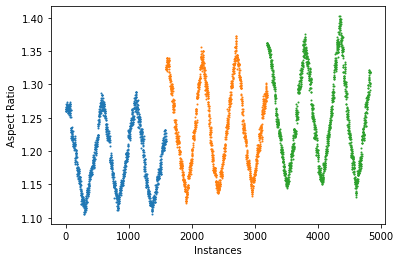

In [761]:
lim1= 1589
lim2= 3194

plt.figure()
plt.plot(dataset.Aspect_Ratio[0:lim1], 'o', markersize=1)
plt.plot(dataset.Aspect_Ratio[lim1:lim2], 'o', markersize=1)
plt.plot(dataset.Aspect_Ratio[lim2:], 'o', markersize=1)
plt.xlabel('Instances')
plt.ylabel('Aspect Ratio')

#### Saved numbered dataset

In [755]:
drop1=np.tile(1, lim1)
drop2=np.tile(2, lim2-lim1)
drop3=np.tile(3, len(raw_dataset)-lim2)

print(len(drop1)+len(drop2)+len(drop3), len(dataset))

drop_number=np.hstack([drop1, drop2, drop3]).T

len(drop_number)

raw_dataset['drop']=drop_number

raw_dataset.tail()

5046 5046


,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,height,width,volume,R_sph,volt,Intensity,time,Power,centre_x,centre_y,surfactant_conc,Aspect_Ratio,ST,drop
5041,0.960475,0.959126,0.959431,0.959751,0.956277,0.954385,0.951222,0.949198,0.950445,0.947987,0.945561,0.940231,0.938339,0.930464,0.919956,0.907742,0.907008,0.902261,0.894412,0.890658,0.885205,0.883509,0.880208,0.840268,0.838368,0.833511,0.825805,0.810264,0.809822,0.806917,0.785716,0.783124,0.761529,0.755347,0.733593,0.730606,0.723270,0.717207,0.713300,0.709990,...,-1.073398,-1.093384,-1.105190,-1.122727,-1.145777,-1.157155,-1.172378,-1.244407,-1.258946,-1.273367,-1.282520,-1.287664,-1.296753,-1.318821,-1.328798,-1.359418,-1.418914,-1.464345,-1.488652,-1.492643,-1.500910,-1.520838,-1.524829,-1.536945,-1.540925,-1.552870,1.342535,1.920092,2.604058,0.853468,9.4,0.345,1175.248753,3.243,2.774954,1.816820,0.904537,1.430199,39.834240,3
5042,0.957232,0.952821,0.953189,0.953573,0.953971,0.952398,0.946041,0.947987,0.945600,0.943284,0.941343,0.932819,0.931085,0.923781,0.910782,0.902821,0.898744,0.890929,0.887021,0.883501,0.875224,0.873660,0.868773,0.834362,0.830425,0.825805,0.820759,0.803647,0.803310,0.800455,0.777838,0.775389,0.757735,0.748948,0.728570,0.725824,0.719050,0.713382,0.706541,0.703532,...,-1.089311,-1.113048,-1.124777,-1.142188,-1.165055,-1.176336,-1.191482,-1.261653,-1.276138,-1.290497,-1.299627,-1.304726,-1.313788,-1.335812,-1.344768,-1.375405,-1.434904,-1.480318,-1.504628,-1.508628,-1.516632,-1.536809,-1.540805,-1.552798,-1.556797,-1.568796,1.342535,1.920092,2.594967,0.852474,9.4,0.345,1175.616762,3.243,2.818940,1.839770,0.907706,1.430199,39.770070,3
5043,0.961966,0.962232,0.962331,0.962719,0.962878,0.959629,0.959476,0.953971,0.954562,0.951392,0.952014,0.947833,0.943633,0.938822,0.936950,0.935153,0.931289,0.921061,0.919885,0.911023,0.891586,0.879218,0.879268,0.871069,0.865103,0.860380,0.851836,0.850607,0.846184,0.808565,0.807569,0.801322,0.794907,0.780279,0.780288,0.777602,0.756382,0.751512,0.734331,0.729854,...,-1.058285,-1.070386,-1.078500,-1.102247,-1.137178,-1.159984,-1.175182,-1.197379,-1.206817,-1.223103,-1.243097,-1.252346,-1.266795,-1.331274,-1.344151,-1.357858,-1.365816,-1.370615,-1.379355,-1.400678,-1.408634,-1.438245,-1.495093,-1.538998,-1.562844,-1.566820,1.331060,1.923917,2.591426,0.852086,9.4,0.345,1175.976768,3.243,2.818940,1.814908,0.908946,1.445402,39.745046,3
5044,0.963888,0.963918,0.964101,0.962377,0.959057,0.959514,0.956193,0.956682,0.955573,0.950068,0.948535,0.946350,0.944237,0.939274,0.931517,0.930000,0.923480,0.904901,0.894412,0.890658,0.883501,0.876819,0.871849,0.864392,0.862995,0.858337,0.819724,0.816021,0.811806,0.804875,0.791513,0.788727,0.788587,0.762499,0.760289,0.741271,0.736092,0.714734,0.712366,0.706479,...,-1.055247,-1.087447,-1.111059,-1.128525,-1.151478,-1.162807,-1.179610,-1.200124,-1.209549,-1.225794,-1.292780,-1.306886,-1.319845,-1.328798,-1.333742,-1.342623,-1.364241,-1.373003,-1.403001,-1.460800,-1.505154,-1.529154,-1.533116,-1.541043,-1.560876,-1.564844,1.327235,1.927742,2.602798,0.853330,9.4,0.345,1176.336757,3.243,2.786429,1.801521,0.904975,1.452450,39.825350,3
5045,0.963964,0.961875,0.962118,0.962377,0.962650,0.960436,0.956682,0.954454,0.955573,0.952974,0.950068,0.944237,0.942198,0.937489,0.922275,0.913037,0.912131,0.907008,0.898744,0.898280,0.888825,0.887021,0.883501,0.843370,0.841268,0.836166,0.828167,0.811806,0.811257,0.810743,0.785744,0.782983,0.763170,0.756634,0.733603,0.730395,0.722552,0.716135,0.708391,0.704747,...,-1.055247,-1.079406,-1.09

In [756]:
path=str('/content/drive/MyDrive/DropLev/Levitator_2/Training/CTAB/numbered_files/')
csvfilename='CTAB.csv'

raw_dataset.to_csv(path+csvfilename, sep=';', header=True)


#### Cappilary length check
 

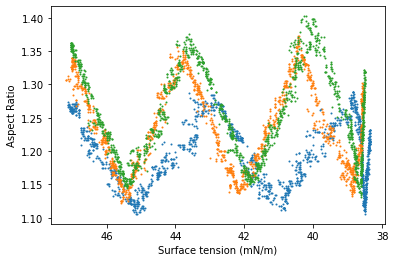

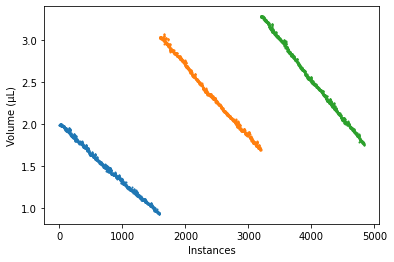

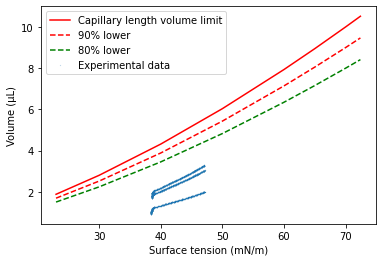

In [718]:
#Cappilary length check

ST_range=np.array([23, 30, 40, 50, 60, 65, 70, 72.4])
volume_range=np.array([1.8825, 2.8043, 4.3175, 6.0340, 7.9318, 8.9437, 9.9953, 10.5137])

plt.figure()
# plt.plot(dataset.ST, dataset.Aspect_Ratio, 'o', markersize=1)
plt.plot(dataset.ST[0:lim1], dataset.Aspect_Ratio[0:lim1], 'o', markersize=1)
plt.plot(dataset.ST[lim1:lim2], dataset.Aspect_Ratio[lim1:lim2], 'o', markersize=1)
plt.plot(dataset.ST[lim2:], dataset.Aspect_Ratio[lim2:], 'o', markersize=1)
plt.gca().invert_xaxis()
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Aspect Ratio')

plt.figure()
# plt.plot(dataset.volume, 'o', markersize=1)
plt.plot(dataset.volume[0:lim1], 'o', markersize=1)
plt.plot(dataset.volume[lim1:lim2], 'o', markersize=1)
plt.plot(dataset.volume[lim2:], 'o', markersize=1)
plt.xlabel('Instances')
plt.ylabel('Volume (μL)')

plt.figure()
plt.plot(ST_range, volume_range, '-r', label='Capillary length volume limit')
plt.plot(ST_range, volume_range*0.9, '--r', label='90% lower')
plt.plot(ST_range, volume_range*0.8, '--g', label='80% lower')
plt.plot(dataset.ST, dataset.volume, 'o', markersize=0.1, label='Experimental data')
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Volume (μL)')
plt.legend()


In [789]:

cut_df1=dataset.iloc[0:lim1]
cut_df2=dataset.iloc[lim2:]  #[0]

if len(cut_df2)>1:
  cut_df=pd.concat([cut_df1, cut_df2]).reset_index()
else:
  cut_df=cut_df1.copy().reset_index()

cut_df.tail()
cut_df.pop('index')

dataset=cut_df.copy()
dataset.tail()

,rho_0,rho_1,rho_2,rho_3,rho_4,rho_5,rho_6,rho_7,rho_8,rho_9,rho_10,rho_11,rho_12,rho_13,rho_14,rho_15,rho_16,rho_17,rho_18,rho_19,rho_20,rho_21,rho_22,rho_23,rho_24,rho_25,rho_26,rho_27,rho_28,rho_29,rho_30,rho_31,rho_32,rho_33,rho_34,rho_35,rho_36,rho_37,rho_38,rho_39,...,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,R_sph,volt,Aspect_Ratio,ST
3222,0.822386,0.823070,0.823239,0.825227,0.825555,0.824092,0.821238,0.818078,0.817721,0.815634,0.813631,0.813586,0.810163,0.808581,0.807087,0.805554,0.797752,0.781719,0.775103,0.769040,0.763541,0.762256,0.759796,0.758620,0.733620,0.722741,0.716765,0.711439,0.708936,0.704215,0.689382,0.688479,0.680292,0.679033,0.674743,0.671057,0.664661,0.662158,0.660377,0.652095,...,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,0.749663,8.92,1.319018,38.500904
3223,0.822386,0.823070,0.823239,0.821416,0.821745,0.820293,0.817461,0.818078,0.813982,0.811903,0.813631,0.809883,0.810163,0.808581,0.807087,0.801922,0.797752,0.778296,0.775103,0.769040,0.763541,0.762256,0.759796,0.758620,0.733620,0.722741,0.716765,0.711439,0.708936,0.704215,0.689382,0.685423,0.680292,0.679033,0.674743,0.671057,0.664661,0.662158,0.660377,0.652095,...,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,0.749398,8.92,1.319018,38.499712
3224,0.822573,0.822786,0.822919,0.823070,0.823426,0.823852,0.822092,0.822457,0.823657,0.822217,0.818954,0.818713,0.813982,0.814799,0.809142,0.807522,0.805990,0.803189,0.800745,0.799657,0.798659,0.794785,0.785676,0.764862,0.759796,0.753192,0.748320,0.745215,0.743564,0.742796,0.716970,0.706155,0.701666,0.694930,0.692980,0.689382,0.674710,0.674743,0.667790,0.667122,...,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,0.750165,8.92,1.319018,38.503163
3225,0.816622,0.817186,0.817338,0.817902,0.819198,0.815699,0.817955,0.814972,0.815573,0.811311,0.809198,0.807171,0.807080,0.803610,0.802007,0.804156,0.798909,0.794612,0.778308,0.775011,0.768833,0.761904,0.760626,0.758179,0.757011,0.732146,0.721336,0.715399,0.710114,0.707627,0.702939,0.691228,0.687334,0.682313,0.681101,0.673345,0.667048,0.664653,0.662890,0.654785,...,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,0.748042,8.92,1.301829,38.493602
3226,0.816649,0.817338,0.817508,0.818125,0.815699,0.816030,0.814595,0.811797,0.812419,0.808375,0.806309,0.808049,0.804329,0.804638,0.799403,0.801596,0.796479,0.792391,0.773169,0.770040,0.764051,0.758632,0.757368,0.754950,0.753796,0.729203,0.718531,0.712674,0.707472,0.705017,0.700395,0.688896,0.68

#### Drop contour points

In [790]:
n_dataset=dataset.copy()

# If we want to drop 150 datapoints then n= 299 

# If we want to drop 125 datapoints then n= 250

n=250
for i in range(0, n, 2):
  dataset.pop('theta_%d' %i)

for i in range(0,n, 2):
  dataset.pop('rho_%d' %i)
dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,R_sph,volt,Aspect_Ratio,ST
3222,0.823070,0.825227,0.824092,0.818078,0.815634,0.813586,0.808581,0.805554,0.781719,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.688479,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.628819,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,0.749663,8.92,1.319018,38.500904
3223,0.823070,0.821416,0.820293,0.818078,0.811903,0.809883,0.808581,0.801922,0.778296,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.685423,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.625050,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,0.749398,8.92,1.319018,38.499712
3224,0.822786,0.823070,0.823852,0.822457,0.822217,0.818713,0.814799,0.807522,0.803189,0.799657,0.794785,0.764862,0.753192,0.745215,0.742796,0.706155,0.694930,0.689382,0.674743,0.667122,0.653507,0.650905,0.638653,0.635265,0.634700,0.627852,0.628819,0.623878,0.622282,0.624406,0.623456,0.621623,0.622646,0.624816,0.624101,0.628132,0.629016,0.632727,0.635035,0.638527,...,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,0.750165,8.92,1.319018,38.503163
3225,0.817186,0.817902,0.815699,0.814972,0.811311,0.807171,0.803610,0.804156,0.794612,0.775011,0.761904,0.758179,0.732146,0.715399,0.707627,0.691228,0.682313,0.673345,0.664653,0.654785,0.649896,0.645412,0.644084,0.638701,0.636487,0.632267,0.634242,0.628821,0.627307,0.627517,0.628333,0.628368,0.629902,0.632914,0.631978,0.634991,0.639480,0.638094,0.640839,0.646340,...,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,0.748042,8.92,1.301829,38.493602
3226,0.817338,0.818125,0.816030,0.811797,0.808375,0.808049,0.804638,0.801596,0.792391,0.770040,0.758632,0.754950,0.729203,0.712674,0.705017,0.688896,0.680123,0.671387,0.662890,0.653219,0.648498,0.644141,0.642902,0.637784,0.635728,0.631642,0.633688,0.628565,0.627354,0.627634,0.628565,0.628856

In [ ]:
# def pol2cart(rho, phi):
#     x = rho * np.cos(phi)
#     y = rho * np.sin(phi)
#     return(x, y)

# #Check that the drop contour is still well defined!

# # For 150 contour datapoints:
# # plt.figure()
# # plt.plot(dataset.iloc[600, 150:300], dataset.iloc[600, 0:150])


# # For 175 contour datapoints:
# n=80

# plt.figure()
# plt.title('Polar coordinates')
# plt.plot(dataset.iloc[n, 175:350], dataset.iloc[n, 0:175], '-o')
# plt.ylabel('Radius, ρ')
# plt.xlabel('Azimuth angle, θ')

# x, y=pol2cart(dataset.iloc[n, 0:175].values, dataset.iloc[n, 175:350].values)

# plt.figure()
# plt.title('Cartesian coordinates')
# plt.plot(x, y, '-o')
# plt.xlabel('x coordinate (mm)')
# plt.ylabel('z coordinate (mm)')

# print(max(dataset.iloc[n, 0:175])-min(dataset.iloc[n, 0:175]))

####Check data distribution

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Shape of new dataset (3227, 355)


,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,R_sph,volt,Aspect_Ratio,ST
3222,0.823070,0.825227,0.824092,0.818078,0.815634,0.813586,0.808581,0.805554,0.781719,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.688479,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.628819,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,0.749663,8.92,1.319018,38.500904
3223,0.823070,0.821416,0.820293,0.818078,0.811903,0.809883,0.808581,0.801922,0.778296,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.685423,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.625050,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,0.749398,8.92,1.319018,38.499712
3224,0.822786,0.823070,0.823852,0.822457,0.822217,0.818713,0.814799,0.807522,0.803189,0.799657,0.794785,0.764862,0.753192,0.745215,0.742796,0.706155,0.694930,0.689382,0.674743,0.667122,0.653507,0.650905,0.638653,0.635265,0.634700,0.627852,0.628819,0.623878,0.622282,0.624406,0.623456,0.621623,0.622646,0.624816,0.624101,0.628132,0.629016,0.632727,0.635035,0.638527,...,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,0.750165,8.92,1.319018,38.503163
3225,0.817186,0.817902,0.815699,0.814972,0.811311,0.807171,0.803610,0.804156,0.794612,0.775011,0.761904,0.758179,0.732146,0.715399,0.707627,0.691228,0.682313,0.673345,0.664653,0.654785,0.649896,0.645412,0.644084,0.638701,0.636487,0.632267,0.634242,0.628821,0.627307,0.627517,0.628333,0.628368,0.629902,0.632914,0.631978,0.634991,0.639480,0.638094,0.640839,0.646340,...,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,0.748042,8.92,1.301829,38.493602
3226,0.817338,0.818125,0.816030,0.811797,0.808375,0.808049,0.804638,0.801596,0.792391,0.770040,0.758632,0.754950,0.729203,0.712674,0.705017,0.688896,0.680123,0.671387,0.662890,0.653219,0.648498,0.644141,0.642902,0.637784,0.635728,0.631642,0.633688,0.628565,0.627354,0.627634,0.628565,0.628856

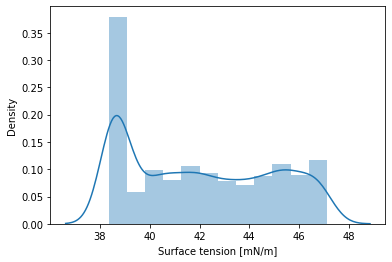

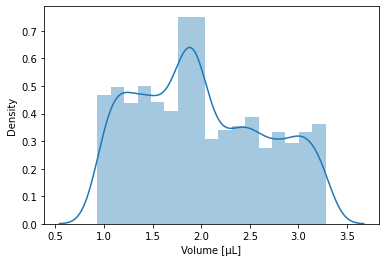

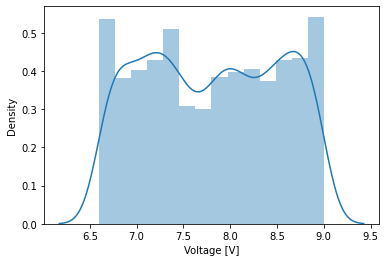

In [791]:
# dataset = dataset[(dataset['volume'] >= 1) & (dataset['volume'] <= 5)]
# dataset = dataset[(dataset['st'] >= 45) & (dataset['st'] <= 65)]
# dataset = dataset[(dataset['volt'] >= 6.5) & (dataset['volt'] <= 8.5)]
# # dataset = dataset[(dataset['Aspect_Ratio'] <= 1.5)]


# plt.figure()
# plt.scatter(dataset.loc[:, 'Aspect_Ratio'], dataset.loc[:, 'centre_y'])
# plt.xlabel('Aspect Ratio')
# plt.ylabel('Position on z-axis [mm]')

plt.figure()
plt.ylabel('Density')
sns.distplot(dataset.loc[:, 'ST'])
plt.xlabel('Surface tension [mN/m]')

plt.figure()
plt.ylabel('Density')
sns.distplot(dataset.loc[:, 'volume'])
plt.xlabel('Volume [μL]')

plt.figure()
plt.ylabel('Density')
sns.distplot(dataset.loc[:, 'volt'])
plt.xlabel('Voltage [V]')

# plt.figure()
# plt.ylabel('Density')
# sns.distplot(dataset.loc[:, 'Aspect_Ratio'])
# plt.xlabel('Aspect Ratio')

print('Shape of new dataset', dataset.shape)
dataset.tail()


#### Calculate the acoustic pressure from the simple model

In [ ]:
new_input=np.asarray(dataset)

In [ ]:
# dataset.iloc[:, 351]

In [ ]:
# # If no contour points were droped
n_ST=353
n_Rsph=351
rho_i=0
rho_f=175
theta_i=175
theta_f=350

Min:  1663.182137647717 Pa, Max: 3139.6230431996564 Pa


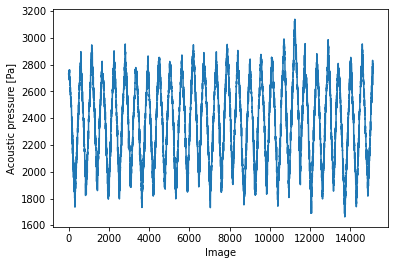

In [ ]:
from lmfit import Model, fit_report, Parameters

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
    rho=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)+R_sph
    return rho


data_Ps=[]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340 #mm^-1

for i in range(len(new_input)):
  gamma=new_input[i, n_ST]
  R_sph=new_input[i, n_Rsph]
  rho=new_input[i, rho_i:rho_f]
  gmodel = Model(model_fit, nan_policy='omit')
    
  fit_param = Parameters()
  fit_param.add('Ps', value=700, min=10, max=4000)
  
  result = gmodel.fit(rho, th=new_input[i, theta_i:theta_f], params=fit_param)         #rho_final, th: x and y to be evaluated, respectively
  Ps=result.params['Ps'].value
  data_Ps.append(Ps)
data_Ps=np.asarray(data_Ps)

plt.figure()
plt.plot(data_Ps)
plt.xlabel('Image')
plt.ylabel('Acoustic pressure [Pa]')

print('Min: ', min(data_Ps), 'Pa, Max:', max(data_Ps), 'Pa')

In [ ]:
dataset['Ps']=data_Ps
dataset.pop('R_sph')

dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST,Ps
15134,0.959126,0.959751,0.954385,0.949198,0.947987,0.940231,0.930464,0.907742,0.902261,0.890658,0.883509,0.840268,0.833511,0.810264,0.806917,0.783124,0.755347,0.730606,0.717207,0.709990,0.705453,0.699977,0.696573,0.687717,0.683845,0.676986,0.677234,0.674257,0.673400,0.672356,0.671540,0.670984,0.672726,0.676240,0.678540,0.681874,0.686577,0.699371,0.701647,0.704893,...,-0.894210,-0.900849,-0.923541,-0.932900,-0.957799,-0.970646,-0.979613,-1.001100,-1.034622,-1.055247,-1.073398,-1.093384,-1.105190,-1.122727,-1.145777,-1.157155,-1.172378,-1.244407,-1.258946,-1.273367,-1.282520,-1.287664,-1.296753,-1.318821,-1.328798,-1.359418,-1.418914,-1.464345,-1.488652,-1.492643,-1.500910,-1.520838,-1.524829,-1.536945,-1.540925,-1.552870,2.604058,9.4,39.834240,2744.499266
15135,0.952821,0.953573,0.952398,0.947987,0.943284,0.932819,0.923781,0.902821,0.890929,0.883501,0.873660,0.834362,0.825805,0.803647,0.800455,0.775389,0.748948,0.725824,0.713382,0.703532,0.699371,0.694354,0.691345,0.686950,0.683695,0.677893,0.674810,0.672258,0.672149,0.671311,0.670242,0.672726,0.674810,0.678540,0.677299,0.684860,0.684358,0.686418,0.692993,0.701647,...,-0.911206,-0.914095,-0.936663,-0.945941,-0.974461,-0.983431,-0.996152,-1.017502,-1.050814,-1.071272,-1.089311,-1.113048,-1.124777,-1.142188,-1.165055,-1.176336,-1.191482,-1.261653,-1.276138,-1.290497,-1.299627,-1.304726,-1.313788,-1.335812,-1.344768,-1.375405,-1.434904,-1.480318,-1.504628,-1.508628,-1.516632,-1.536809,-1.540805,-1.552798,-1.556797,-1.568796,2.594967,9.4,39.770070,2738.949214
15136,0.962232,0.962719,0.959629,0.953971,0.951392,0.947833,0.938822,0.935153,0.921061,0.911023,0.879218,0.871069,0.860380,0.850607,0.808565,0.801322,0.780279,0.777602,0.751512,0.729854,0.705650,0.696352,0.689193,0.682796,0.679412,0.677806,0.672530,0.667486,0.665082,0.663430,0.662327,0.665533,0.662327,0.668855,0.674160,0.676813,0.681670,0.684283,0.691091,0.709423,...,-0.891596,-0.920253,-0.926826,-0.936165,-0.973848,-0.976428,-0.995475,-0.997954,-1.019141,-1.031536,-1.058285,-1.070386,-1.078500,-1.102247,-1.137178,-1.159984,-1.175182,-1.197379,-1.206817,-1.223103,-1.243097,-1.252346,-1.266795,-1.331274,-1.344151,-1.357858,-1.365816,-1.370615,-1.379355,-1.400678,-1.408634,-1.438245,-1.495093,-1.538998,-1.562844,-1.566820,2.591426,9.4,39.745046,2786.105399
15137,0.963918,0.962377,0.959514,0.956682,0.950068,0.946350,0.939274,0.930000,0.904901,0.890658,0.876819,0.864392,0.858337,0.816021,0.804875,0.788727,0.762499,0.741271,0.714734,0.706479,0.695364,0.690021,0.685426,0.680424,0.677493,0.673574,0.667826,0.665632,0.662989,0.660900,0.663662,0.664157,0.663783,0.667289,0.668986,0.676467,0.677957,0.684133,0.690328,0.703074,...,-0.891241,-0.930108,-0.932900,-0.948658,-0.955130,-0.973240,-0.985970,-1.013640,-1.022247,-1.034622,-1.055247,-1.087447,-1.111059,-1.128525,-1.151478,-1.162807,-1.179610,-1.200124,-1.209549,-1.225794,-1.292780,-1.306886,-1.319845,-1.328798,-1.333742,-1.342623,-1.364241,-1.373003,-1.403001,-1.460800,-1.505154,-1.529154,-1.533116,-1.541043,-1.560876,-1.564844,2.602798,9.4,39.825350,2800.753844
15138,0.961875,0.962377,0.960436,0.954454,0.952974,0.944237,0.937489,0.913037,0.907008,0.898280,0.887021,0.843370,0.836166,0.811806,0.810743,0.782983,0.756634,0.730395,0.716135,0.704747,0.699800,0.697350,0.693574,0.683994,0.679606,0.671877,0.671757,0.668428,0.667585,0.666433,0.6636

#### Generate contours based on experimental data

0
10000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

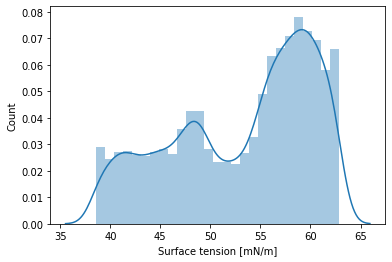

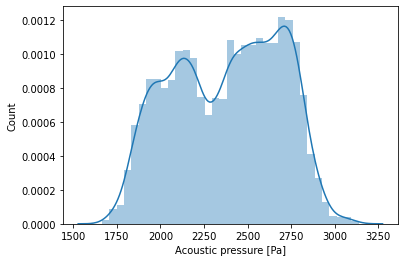

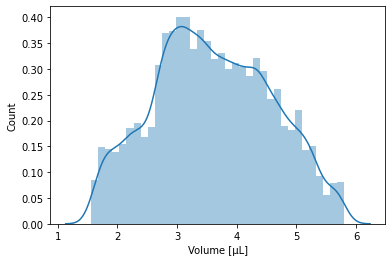

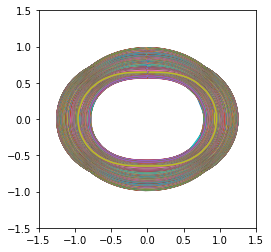

In [ ]:
def gen_data(num_sample,sampling, vol, Ps, st):
 
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 

    theta=np.random.rand(num_sample, sampling)*np.pi*2
    theta.sort()
    
    # ST_range=np.random.random(num_sample)*(72.4-37)+37
    r_all=np.empty([0,sampling])

    for i in range(num_sample):
        R_sph=calc_R_sph(vol[i])
        r=R_predict(theta[i], st[i], R_sph, Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
        if i % 10000 == 0:
                print(i)
        
    dataset=np.hstack((r_all, theta, vol.values.reshape([num_sample, 1]), Ps.values.reshape([num_sample,1]), st.values.reshape([num_sample,1])))

    plt.figure()
    plt.ylabel('Count')
    sns.distplot(st)
    plt.xlabel('Surface tension [mN/m]')

    plt.figure()
    plt.ylabel('Count')
    sns.distplot(Ps)
    plt.xlabel('Acoustic pressure [Pa]')

    plt.figure()
    plt.ylabel('Count')
    sns.distplot(vol)
    plt.xlabel('Volume [μL]')


    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[0:sampling], j[sampling:sampling+sampling])

      plt.plot(x, y)

    plt.show()
    return dataset

num_sample=len(dataset) # number of different ST values
sampling=175 # number of coordiante point describing the contour


new_dataset=gen_data(num_sample,sampling, dataset.volume, dataset.Ps, dataset.ST)


column_names=[]
for i in range(sampling):
  column_names.append('rho')
for i in range(sampling):
  column_names.append('theta')
column_names.append('volume')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(new_dataset, columns=column_names)




In [ ]:
new_dataset=raw_dataset.copy()
new_dataset.pop('Ps')
new_dataset['volt']=dataset.volt
new_dataset.tail()

In [ ]:
dataset=raw_dataset.copy()
dataset.tail()

plt.figure()
plt.ylabel('Count')
sns.distplot(dataset.volt)
plt.xlabel('Voltage [V]')


,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,volume,Ps,ST
15134,0.656766,0.680163,0.688578,0.696709,0.724990,0.726600,0.731264,0.744422,0.765644,0.768784,0.794255,0.824239,0.826536,0.849118,0.881620,0.891042,0.913133,0.914014,0.932033,0.934175,0.950600,0.952495,0.952652,0.949847,0.949686,0.948561,0.947909,0.947067,0.943990,0.940678,0.936953,0.933939,0.930759,0.927665,0.926688,0.916168,0.910515,0.908236,0.902656,0.899375,...,4.892745,4.940272,4.950210,5.024587,5.059181,5.074320,5.078614,5.162543,5.200463,5.231009,5.251683,5.280093,5.379972,5.438218,5.455876,5.461206,5.600778,5.604193,5.675941,5.703906,5.720559,5.723747,5.733952,5.749668,5.790971,5.830183,5.848778,5.874093,5.886100,5.890811,5.952379,6.070047,6.148157,6.184281,6.218913,6.235897,6.277486,2.604058,2744.499266,39.834240
15135,0.655369,0.656164,0.657966,0.658712,0.662996,0.665309,0.665688,0.679500,0.727277,0.729149,0.747064,0.750798,0.783870,0.811839,0.817553,0.823741,0.847362,0.865908,0.871181,0.879064,0.885021,0.887188,0.888058,0.890764,0.891413,0.907334,0.908292,0.912704,0.915907,0.917837,0.922143,0.923816,0.924120,0.937335,0.937942,0.938695,0.942265,0.946597,0.946877,0.948365,...,4.622358,4.628371,4.637260,4.637510,4.677878,4.758857,4.882992,4.883159,4.981562,5.022248,5.023014,5.064591,5.078870,5.108788,5.246225,5.336148,5.364792,5.429540,5.451312,5.511632,5.626016,5.653890,5.721285,5.752781,5.796759,5.807541,5.937640,5.966943,5.969773,5.976119,5.978969,5.979787,6.153164,6.201668,6.230279,6.243611,6.246306,2.594967,2738.949214,39.770070
15136,0.649777,0.655709,0.656026,0.667450,0.669226,0.672589,0.673930,0.676749,0.679676,0.683376,0.696854,0.711653,0.720948,0.722655,0.740416,0.788387,0.790228,0.797505,0.809984,0.811239,0.821265,0.834329,0.878551,0.889298,0.892513,0.893603,0.914015,0.914746,0.916219,0.920946,0.921961,0.925694,0.930541,0.940536,0.950831,0.951195,0.951838,0.953063,0.953441,0.951874,...,5.036766,5.070520,5.075027,5.138752,5.188091,5.202973,5.205264,5.233258,5.244833,5.303187,5.304423,5.350830,5.365556,5.371286,5.457733,5.612331,5.622803,5.656262,5.694556,5.738195,5.769705,5.789632,5.809553,5.859755,5.916725,5.974149,5.989559,5.996366,6.025300,6.095380,6.116049,6.119650,6.140072,6.190730,6.248475,6.262148,6.277338,2.591426,2786.105399,39.745046
15137,0.647025,0.648520,0.653785,0.658500,0.658684,0.660705,0.662498,0.680477,0.681231,0.686311,0.689017,0.724228,0.741138,0.754330,0.771243,0.772360,0.773193,0.792806,0.806294,0.810711,0.812869,0.829584,0.839631,0.845837,0.892279,0.906519,0.930414,0.931135,0.935149,0.939523,0.955813,0.956002,0.956500,0.956575,0.956616,0.956627,0.955895,0.953352,0.950673,0.948565,...,4.978146,4.986617,5.034563,5.127754,5.128307,5.130105,5.141655,5.203902,5.210789,5.252736,5.344912,5.376206,5.407243,5.436302,5.441579,5.480288,5.515903,5.553443,5.570352,5.605019,5.653942,5.792742,5.818316,5.841498,5.845450,5.876158,5.893915,5.923930,5.960564,5.979642,6.006786,6.013934,6.134596,6.189220,6.235671,6.259720,6.270388,2.602798,2800.753844,39.825350
15138,0.648252,0.651980,0.652286,0.653878,0.659026,0.661050,0.662650,0.668915,0.673401,0.674710,0.676116,0.676248,0.689315,0.692225,0.692756,0.694191,0.696152,0.718280,0.722333,0.725245,0.735387,0.737837,0.740336,0.768801,0.783882,0.789240,0.793531,0.800582,0.807086,0.813028,0.835273,0.846399,0.899187,0.904690,0.904934,0.925541,0.928621,0.931010,0.933752,0.934913,...,4.625072,4.644437,4.720319,4.765496,4.844707,4.995575,5.061136,5.080227,5.215171,5.347534,5.386616,5.424778,5.437641,5.483203,5.487023,5.545236,5.558701,5.562197,5.590497,5.605318,5.636367,5.665196,5.709658,5.718061,5.729746,5.832672,5.837312,5.886005,5.907677,6.061117,6.079860,6.080766,6.0979

#### Generate theoretical data based on experimental data distribution

0
10000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

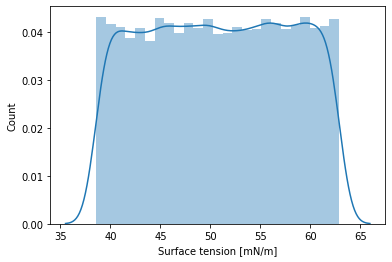

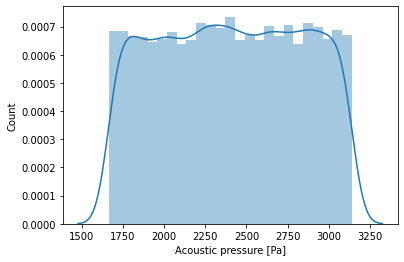

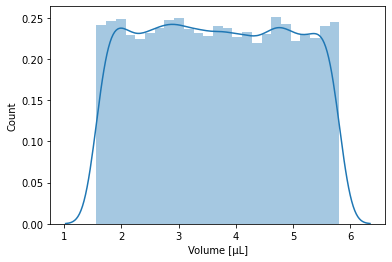

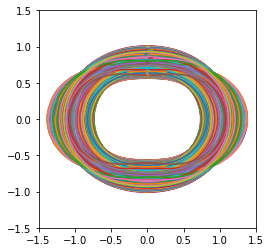

In [ ]:
def gen_data(num_sample,sampling, volmin, volmax, Psmin, Psmax, stmin, stmax):

    #np.random.seed(1234)

    vol_drop=np.random.random(num_sample)*(volmax-volmin)+volmin # [µL]
    # vol_drop=np.tile(vol_drop, num_sample)   # If the volume is constant !!!

    #gamma=72.8 #[mN/m]   
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air in [mm^-1]. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 

    Ps=np.random.random(num_sample)*(Psmax-Psmin)+Psmin  #[Pa]
    R_sph=calc_R_sph(vol_drop)

    theta=np.random.rand(num_sample, sampling)*np.pi*2
    theta.sort()
    
    ST_range=np.random.random(num_sample)*(stmax-stmin)+stmin #[mN/m]
    r_all=np.empty([0,sampling])


    for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph[i], Ps[i], Cg_air, k_o)
        r_all=np.vstack((r_all, r))
        
        if i % 10000 == 0:
                print(i)
        
    
    dataset=np.hstack((r_all, theta, vol_drop.reshape([num_sample, 1]), Ps.reshape([num_sample,1]), ST_range.reshape([num_sample,1])))

    # print(ST_range.min())
    # print(ST_range.max())

    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Surface tension [mN/m]')
    sns.distplot(ST_range)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Acoustic pressure [Pa]')
    sns.distplot(Ps)
    plt.figure()
    plt.ylabel('Count')
    plt.xlabel('Volume [μL]')
    sns.distplot(vol_drop)

    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[0:sampling], j[sampling:sampling+sampling])

      plt.plot(x, y)

    plt.show()
    return dataset

num_sample=len(dataset) # number of different ST values
sampling=175 # number of coordiante point describing the contour

volmin=min(dataset.volume)
volmax=max(dataset.volume)
Psmin=min(dataset.Ps)
Psmax=max(dataset.Ps)
stmin=min(dataset.ST)
stmax=max(dataset.ST)



new_dataset=gen_data(num_sample,sampling, volmin, volmax, Psmin, Psmax, stmin, stmax)


column_names=[]
for i in range(sampling):
  column_names.append('rho')
for i in range(sampling):
  column_names.append('theta')
column_names.append('volume')
column_names.append('Ps')
column_names.append('ST')


raw_dataset = pd.DataFrame(new_dataset, columns=column_names)

# raw_dataset.to_csv('./dataset.csv',index=False)









In [ ]:
# Change the range of Ps into the Voltage range

OldMax=max(raw_dataset.Ps)
OldMin=min(raw_dataset.Ps)
NewMax=max(dataset.volt)
NewMin=min(dataset.volt)
NewValues=[]

OldRange = (OldMax - OldMin)
for i in range(len(raw_dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewRange = (NewMax - NewMin)  
      NewValue = (((raw_dataset.Ps[i] - OldMin) * NewRange) / OldRange) + NewMin
      NewValues.append(NewValue)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


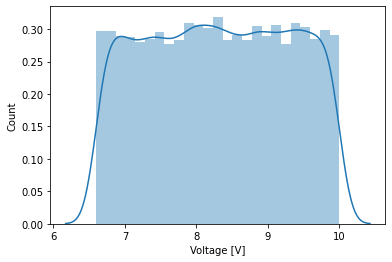

In [ ]:
plt.figure()
plt.ylabel('Count')
plt.xlabel('Voltage [V]')
sns.distplot(NewValues)

In [ ]:
raw_dataset.pop('Ps')

raw_dataset['volt']=NewValues

raw_dataset.tail()


,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,volume,ST,volt
15134,0.740054,0.740080,0.740216,0.742586,0.749546,0.750232,0.765450,0.766224,0.766962,0.769451,0.780740,0.780958,0.784478,0.793436,0.811514,0.815571,0.820725,0.820865,0.825407,0.831453,0.831484,0.844510,0.869009,0.875516,0.893360,0.904001,0.909514,0.913323,0.914495,0.922455,0.927209,0.932803,0.937589,0.939098,0.942772,0.948459,0.976487,0.976521,0.983131,0.983694,...,4.841129,4.842633,4.924779,4.942012,4.977271,4.993588,5.069589,5.095706,5.102907,5.124399,5.155699,5.190756,5.199976,5.353477,5.370047,5.387773,5.435062,5.633706,5.646257,5.653126,5.767253,5.788822,5.867480,5.889835,5.956236,5.965139,5.980988,6.021108,6.079525,6.090637,6.121912,6.167914,6.185794,6.188848,6.249333,6.254169,6.280902,3.079494,58.079569,9.166490
15135,0.607745,0.631826,0.646322,0.649125,0.650045,0.655194,0.657381,0.667176,0.668279,0.676163,0.680817,0.697327,0.704455,0.712857,0.713442,0.727297,0.728625,0.746383,0.760044,0.779300,0.783772,0.820036,0.826571,0.876217,0.884521,0.899748,0.920881,0.934402,0.949306,0.963589,0.974090,0.979640,0.983688,1.001733,1.010043,1.024011,1.030711,1.034754,1.046929,1.050296,...,5.099866,5.238139,5.276715,5.277524,5.314561,5.357289,5.377667,5.427674,5.447217,5.478796,5.487511,5.542099,5.555862,5.560097,5.644131,5.651135,5.679980,5.685009,5.723593,5.792279,5.805501,5.856084,5.893658,5.921342,6.011983,6.014029,6.037809,6.037868,6.091036,6.099543,6.123583,6.129533,6.144304,6.144936,6.169266,6.182102,6.219413,3.181144,38.732907,9.882337
15136,0.923951,0.926391,0.927668,0.933381,0.933483,0.934713,0.939708,0.946170,0.946584,0.949273,0.950058,0.955144,0.955244,0.965646,0.967635,0.967657,0.968933,0.973482,0.981468,0.982738,0.987258,0.987709,0.996459,1.003768,1.012950,1.020091,1.022652,1.026262,1.046376,1.050526,1.051597,1.052516,1.066395,1.077600,1.083377,1.089625,1.093734,1.094486,1.099511,1.100460,...,4.707223,4.760321,4.774045,4.781144,4.785547,4.911137,4.963704,5.059393,5.063795,5.064128,5.104316,5.159631,5.183019,5.209044,5.257248,5.264266,5.280551,5.323085,5.431542,5.434540,5.467839,5.519314,5.536329,5.601791,5.619789,5.626271,5.639358,5.675408,5.709445,5.755647,5.770450,5.907267,5.981792,6.105261,6.149975,6.212036,6.268089,4.931033,59.257276,7.432823
15137,0.733104,0.733314,0.734591,0.735316,0.735912,0.739937,0.742124,0.744727,0.748610,0.750288,0.758416,0.761002,0.761534,0.764379,0.766532,0.784005,0.792921,0.810449,0.811784,0.830902,0.835965,0.837984,0.844881,0.849852,0.850626,0.870222,0.878606,0.887764,0.890775,0.896419,0.911259,0.925668,0.938169,0.940048,0.942807,0.944091,0.954435,0.969059,0.971657,0.979152,...,4.907828,4.924493,4.960442,4.999531,5.073532,5.078561,5.080412,5.137419,5.144948,5.177699,5.210905,5.225972,5.280021,5.343514,5.356684,5.458205,5.504828,5.522810,5.542547,5.561787,5.740836,5.776401,5.794613,5.816171,5.819606,5.850765,5.883782,5.932506,5.971104,6.075959,6.083271,6.091891,6.131720,6.136478,6.182173,6.226728,6.235557,3.450492,39.203098,8.359517
15138,0.931352,0.931412,0.931566,0.932071,0.932142,0.932836,0.933112,0.933290,0.935887,0.938545,0.940615,0.943075,0.949614,0.954890,0.956680,0.960349,0.991459,0.997081,1.013115,1.014746,1.016422,1.019035,1.039841,1.040101,1.045268,1.056187,1.060104,1.066951,1.075915,1.075954,1.076200,1.077427,1.081776,1.101551,1.105586,1.109737,1.113420,1.116000,1.131286,1.137410,...,4.838921,4.872736,4.892063,4.908175,4.916005,4.929412,4.931057,4.983403,5.064862,5.083908,5.156536,5.158578,5.237987,5.242310,5.268131,5.289394,5.472871,5.500694,5.510360,5.678601,5.713142,5.754769,5.777175,5.807230,5.843955,5.875791,5.906549,5.941447,5.990857,6.008710,6.056129,6.129859,6.182779,6.21448

In [ ]:
# dataset_saved=dataset.copy()

dataset=dataset_saved.copy()
# dataset_saved.pop('Ps')
# dataset_saved.tail()

In [ ]:
dataset=raw_dataset.copy()
dataset.tail()


,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,volume,ST,volt
15134,0.740054,0.740080,0.740216,0.742586,0.749546,0.750232,0.765450,0.766224,0.766962,0.769451,0.780740,0.780958,0.784478,0.793436,0.811514,0.815571,0.820725,0.820865,0.825407,0.831453,0.831484,0.844510,0.869009,0.875516,0.893360,0.904001,0.909514,0.913323,0.914495,0.922455,0.927209,0.932803,0.937589,0.939098,0.942772,0.948459,0.976487,0.976521,0.983131,0.983694,...,4.841129,4.842633,4.924779,4.942012,4.977271,4.993588,5.069589,5.095706,5.102907,5.124399,5.155699,5.190756,5.199976,5.353477,5.370047,5.387773,5.435062,5.633706,5.646257,5.653126,5.767253,5.788822,5.867480,5.889835,5.956236,5.965139,5.980988,6.021108,6.079525,6.090637,6.121912,6.167914,6.185794,6.188848,6.249333,6.254169,6.280902,3.079494,58.079569,9.166490
15135,0.607745,0.631826,0.646322,0.649125,0.650045,0.655194,0.657381,0.667176,0.668279,0.676163,0.680817,0.697327,0.704455,0.712857,0.713442,0.727297,0.728625,0.746383,0.760044,0.779300,0.783772,0.820036,0.826571,0.876217,0.884521,0.899748,0.920881,0.934402,0.949306,0.963589,0.974090,0.979640,0.983688,1.001733,1.010043,1.024011,1.030711,1.034754,1.046929,1.050296,...,5.099866,5.238139,5.276715,5.277524,5.314561,5.357289,5.377667,5.427674,5.447217,5.478796,5.487511,5.542099,5.555862,5.560097,5.644131,5.651135,5.679980,5.685009,5.723593,5.792279,5.805501,5.856084,5.893658,5.921342,6.011983,6.014029,6.037809,6.037868,6.091036,6.099543,6.123583,6.129533,6.144304,6.144936,6.169266,6.182102,6.219413,3.181144,38.732907,9.882337
15136,0.923951,0.926391,0.927668,0.933381,0.933483,0.934713,0.939708,0.946170,0.946584,0.949273,0.950058,0.955144,0.955244,0.965646,0.967635,0.967657,0.968933,0.973482,0.981468,0.982738,0.987258,0.987709,0.996459,1.003768,1.012950,1.020091,1.022652,1.026262,1.046376,1.050526,1.051597,1.052516,1.066395,1.077600,1.083377,1.089625,1.093734,1.094486,1.099511,1.100460,...,4.707223,4.760321,4.774045,4.781144,4.785547,4.911137,4.963704,5.059393,5.063795,5.064128,5.104316,5.159631,5.183019,5.209044,5.257248,5.264266,5.280551,5.323085,5.431542,5.434540,5.467839,5.519314,5.536329,5.601791,5.619789,5.626271,5.639358,5.675408,5.709445,5.755647,5.770450,5.907267,5.981792,6.105261,6.149975,6.212036,6.268089,4.931033,59.257276,7.432823
15137,0.733104,0.733314,0.734591,0.735316,0.735912,0.739937,0.742124,0.744727,0.748610,0.750288,0.758416,0.761002,0.761534,0.764379,0.766532,0.784005,0.792921,0.810449,0.811784,0.830902,0.835965,0.837984,0.844881,0.849852,0.850626,0.870222,0.878606,0.887764,0.890775,0.896419,0.911259,0.925668,0.938169,0.940048,0.942807,0.944091,0.954435,0.969059,0.971657,0.979152,...,4.907828,4.924493,4.960442,4.999531,5.073532,5.078561,5.080412,5.137419,5.144948,5.177699,5.210905,5.225972,5.280021,5.343514,5.356684,5.458205,5.504828,5.522810,5.542547,5.561787,5.740836,5.776401,5.794613,5.816171,5.819606,5.850765,5.883782,5.932506,5.971104,6.075959,6.083271,6.091891,6.131720,6.136478,6.182173,6.226728,6.235557,3.450492,39.203098,8.359517
15138,0.931352,0.931412,0.931566,0.932071,0.932142,0.932836,0.933112,0.933290,0.935887,0.938545,0.940615,0.943075,0.949614,0.954890,0.956680,0.960349,0.991459,0.997081,1.013115,1.014746,1.016422,1.019035,1.039841,1.040101,1.045268,1.056187,1.060104,1.066951,1.075915,1.075954,1.076200,1.077427,1.081776,1.101551,1.105586,1.109737,1.113420,1.116000,1.131286,1.137410,...,4.838921,4.872736,4.892063,4.908175,4.916005,4.929412,4.931057,4.983403,5.064862,5.083908,5.156536,5.158578,5.237987,5.242310,5.268131,5.289394,5.472871,5.500694,5.510360,5.678601,5.713142,5.754769,5.777175,5.807230,5.843955,5.875791,5.906549,5.941447,5.990857,6.008710,6.056129,6.129859,6.182779,6.21448

##### Combine the best of the 2 worlds

In [ ]:
# dataset_saved.pop('Ps')
# dataset_saved.pop('R_sph')

Voltage=dataset_saved.pop('volt')
dataset_saved['volt']=Voltage

# dataset_saved.tail()

dataset = pd.DataFrame(np.concatenate([dataset_saved.values, raw_dataset.values]), columns=dataset_saved.columns)

dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,ST,volt
30273,0.740054,0.740080,0.740216,0.742586,0.749546,0.750232,0.765450,0.766224,0.766962,0.769451,0.780740,0.780958,0.784478,0.793436,0.811514,0.815571,0.820725,0.820865,0.825407,0.831453,0.831484,0.844510,0.869009,0.875516,0.893360,0.904001,0.909514,0.913323,0.914495,0.922455,0.927209,0.932803,0.937589,0.939098,0.942772,0.948459,0.976487,0.976521,0.983131,0.983694,...,4.841129,4.842633,4.924779,4.942012,4.977271,4.993588,5.069589,5.095706,5.102907,5.124399,5.155699,5.190756,5.199976,5.353477,5.370047,5.387773,5.435062,5.633706,5.646257,5.653126,5.767253,5.788822,5.867480,5.889835,5.956236,5.965139,5.980988,6.021108,6.079525,6.090637,6.121912,6.167914,6.185794,6.188848,6.249333,6.254169,6.280902,3.079494,58.079569,9.166490
30274,0.607745,0.631826,0.646322,0.649125,0.650045,0.655194,0.657381,0.667176,0.668279,0.676163,0.680817,0.697327,0.704455,0.712857,0.713442,0.727297,0.728625,0.746383,0.760044,0.779300,0.783772,0.820036,0.826571,0.876217,0.884521,0.899748,0.920881,0.934402,0.949306,0.963589,0.974090,0.979640,0.983688,1.001733,1.010043,1.024011,1.030711,1.034754,1.046929,1.050296,...,5.099866,5.238139,5.276715,5.277524,5.314561,5.357289,5.377667,5.427674,5.447217,5.478796,5.487511,5.542099,5.555862,5.560097,5.644131,5.651135,5.679980,5.685009,5.723593,5.792279,5.805501,5.856084,5.893658,5.921342,6.011983,6.014029,6.037809,6.037868,6.091036,6.099543,6.123583,6.129533,6.144304,6.144936,6.169266,6.182102,6.219413,3.181144,38.732907,9.882337
30275,0.923951,0.926391,0.927668,0.933381,0.933483,0.934713,0.939708,0.946170,0.946584,0.949273,0.950058,0.955144,0.955244,0.965646,0.967635,0.967657,0.968933,0.973482,0.981468,0.982738,0.987258,0.987709,0.996459,1.003768,1.012950,1.020091,1.022652,1.026262,1.046376,1.050526,1.051597,1.052516,1.066395,1.077600,1.083377,1.089625,1.093734,1.094486,1.099511,1.100460,...,4.707223,4.760321,4.774045,4.781144,4.785547,4.911137,4.963704,5.059393,5.063795,5.064128,5.104316,5.159631,5.183019,5.209044,5.257248,5.264266,5.280551,5.323085,5.431542,5.434540,5.467839,5.519314,5.536329,5.601791,5.619789,5.626271,5.639358,5.675408,5.709445,5.755647,5.770450,5.907267,5.981792,6.105261,6.149975,6.212036,6.268089,4.931033,59.257276,7.432823
30276,0.733104,0.733314,0.734591,0.735316,0.735912,0.739937,0.742124,0.744727,0.748610,0.750288,0.758416,0.761002,0.761534,0.764379,0.766532,0.784005,0.792921,0.810449,0.811784,0.830902,0.835965,0.837984,0.844881,0.849852,0.850626,0.870222,0.878606,0.887764,0.890775,0.896419,0.911259,0.925668,0.938169,0.940048,0.942807,0.944091,0.954435,0.969059,0.971657,0.979152,...,4.907828,4.924493,4.960442,4.999531,5.073532,5.078561,5.080412,5.137419,5.144948,5.177699,5.210905,5.225972,5.280021,5.343514,5.356684,5.458205,5.504828,5.522810,5.542547,5.561787,5.740836,5.776401,5.794613,5.816171,5.819606,5.850765,5.883782,5.932506,5.971104,6.075959,6.083271,6.091891,6.131720,6.136478,6.182173,6.226728,6.235557,3.450492,39.203098,8.359517
30277,0.931352,0.931412,0.931566,0.932071,0.932142,0.932836,0.933112,0.933290,0.935887,0.938545,0.940615,0.943075,0.949614,0.954890,0.956680,0.960349,0.991459,0.997081,1.013115,1.014746,1.016422,1.019035,1.039841,1.040101,1.045268,1.056187,1.060104,1.066951,1.075915,1.075954,1.076200,1.077427,1.081776,1.101551,1.105586,1.109737,1.113420,1.116000,1.131286,1.137410,...,4.838921,4.872736,4.892063,4.908175,4.916

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 0, 'Volume [μL]')

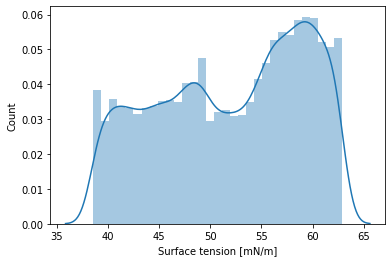

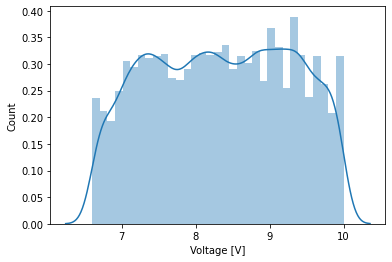

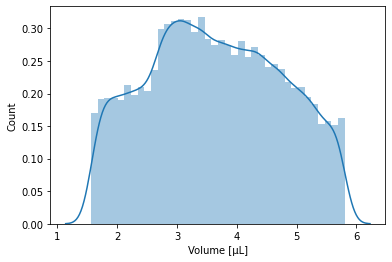

In [ ]:
plt.figure()
plt.ylabel('Count')
sns.distplot(dataset.ST)
plt.xlabel('Surface tension [mN/m]')

plt.figure()
plt.ylabel('Count')
sns.distplot(dataset.volt)
plt.xlabel('Voltage [V]')

plt.figure()
plt.ylabel('Count')
sns.distplot(dataset.volume)
plt.xlabel('Volume [μL]')


#### Shuffle dataset

,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,volume,Ps,ST
21243,0.924409,0.924973,0.925527,0.925742,0.926858,0.927151,0.928312,0.928599,0.928903,0.929987,0.931456,0.931891,0.932683,0.934648,0.935641,0.936926,0.939038,0.944552,0.964242,0.966088,0.971641,0.978754,0.980687,0.990762,0.995156,0.995377,0.995557,1.000238,1.001393,1.001705,1.003265,1.004496,1.005037,1.016389,1.018715,1.019749,1.027015,1.028126,1.029146,1.029365,...,5.002030,5.043683,5.108903,5.166262,5.236471,5.254175,5.270958,5.318312,5.372518,5.394879,5.396503,5.403825,5.435777,5.465968,5.484012,5.487768,5.499425,5.539738,5.549917,5.557791,5.645231,5.651996,5.672345,5.681562,5.722059,5.773186,5.815350,5.862115,5.872686,5.907819,5.916547,6.050294,6.196812,6.206533,6.219366,6.223271,6.279448,4.394526,1610.777432,48.073350
45891,0.693284,0.693364,0.693487,0.693613,0.693957,0.694299,0.694424,0.695059,0.696119,0.697465,0.697930,0.698754,0.700034,0.702123,0.706600,0.706949,0.714207,0.720927,0.721447,0.722480,0.726368,0.731067,0.735097,0.735120,0.736127,0.739641,0.742445,0.743184,0.743325,0.743395,0.745441,0.749218,0.753212,0.755120,0.758945,0.765410,0.765686,0.767290,0.770133,0.771686,...,4.590355,4.602314,4.610125,4.713809,4.728917,4.735150,4.822281,4.862810,4.897144,4.923537,4.931321,5.001280,5.018818,5.020152,5.027356,5.111774,5.183601,5.213898,5.302487,5.356035,5.364048,5.417078,5.505087,5.568659,5.629434,5.705644,5.771050,5.774046,5.819907,5.933042,5.944703,6.032582,6.070173,6.155412,6.183558,6.221194,6.226865,1.830912,2067.769691,49.926967
42613,0.658699,0.659377,0.659710,0.659730,0.659954,0.660407,0.660999,0.661962,0.662035,0.662866,0.663019,0.664645,0.664905,0.665263,0.665532,0.667586,0.668785,0.672035,0.674867,0.677075,0.678617,0.678840,0.680587,0.684192,0.686651,0.687142,0.687653,0.691236,0.694246,0.695063,0.700495,0.700905,0.701652,0.703991,0.705232,0.705467,0.705672,0.705729,0.705791,0.705822,...,5.071663,5.083426,5.189874,5.202443,5.207188,5.232545,5.237654,5.270687,5.280193,5.316785,5.330060,5.451010,5.593291,5.614820,5.640703,5.651349,5.683105,5.690630,5.691908,5.703486,5.725354,5.759379,5.828797,5.847073,5.867858,5.886654,5.893825,5.906048,5.921536,5.946695,6.073266,6.118263,6.118660,6.141298,6.166575,6.179449,6.195695,1.375432,1617.236586,49.285569
43567,0.695597,0.695742,0.697822,0.698121,0.698445,0.698455,0.698478,0.701530,0.702012,0.702237,0.703760,0.705237,0.709347,0.713049,0.713143,0.718102,0.719721,0.724086,0.724785,0.725553,0.729148,0.729353,0.732331,0.744621,0.750923,0.751791,0.754325,0.754734,0.769491,0.774687,0.793812,0.800255,0.802833,0.811328,0.818701,0.834485,0.836683,0.838527,0.839239,0.840358,...,4.869043,4.875867,4.887088,4.958826,5.000715,5.053591,5.058968,5.070042,5.101680,5.160140,5.200354,5.210800,5.258469,5.264448,5.396748,5.442078,5.496532,5.515051,5.534917,5.548555,5.583912,5.595558,5.684025,5.696218,5.696655,5.750766,5.833919,5.869700,5.879251,5.930900,5.963965,5.986870,6.137538,6.162259,6.178710,6.225806,6.275229,2.084695,2722.738434,65.822269
2732,0.561606,0.561808,0.562142,0.564509,0.568317,0.577583,0.581198,0.592331,0.605357,0.609149,0.622381,0.631230,0.634864,0.638270,0.642894,0.671421,0.673630,0.684495,0.714790,0.739982,0.746073,0.774507,0.785389,0.799652,0.809617,0.815576,0.822861,0.852091,0.901988,0.924865,0.934896,0.942239,0.962330,0.966927,0.968210,0.973830,0.998762,1.004707,1.019139,1.023021,...,5.043688,5.125698,5.135777,5.148827,5.164388,5.171505,5.279338,5.341316,5.348365,5.349814,5.358770,5.362077,5.381054,5.485593,5.509628,5.517602,5.543289,5.555563,5.624453,5.637795,5.663127,5.750096,5.762920,5.788467,5.798251,5.839530,5.873041,5.960771,5.994174,6.041139,6.043400,6.100832,6.14683

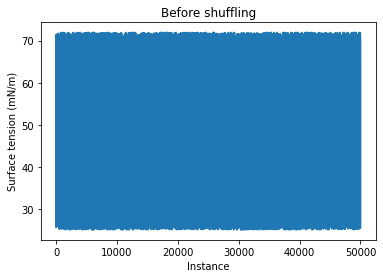

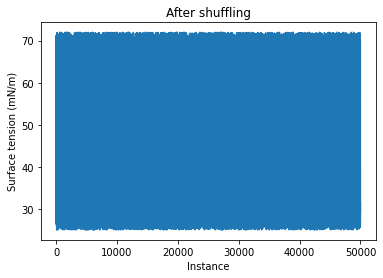

In [ ]:
from sklearn.utils import shuffle

plt.figure()
plt.title('Before shuffling')
plt.plot(range(len(dataset)), dataset.ST)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')

dataset=shuffle(dataset, random_state=0)

plt.figure()
plt.title('After shuffling')
plt.plot(range(len(dataset)), dataset.ST)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')

dataset.tail()

### Check dataset

In [ ]:
#Remove columns

# Ps=raw_dataset.pop('Ps')
# volume=raw_dataset.pop('vol')

In [ ]:

#input = pd.read_csv(io.BytesIO(uploaded['data.csv']))
#input = pd.DataFrame(dataset)
# Dataset is now stored in a Pandas Dataframe
#input.size


(100000, 353)

In [ ]:
# loading of data
# raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
# dataset.pop('vol')
dataset.tail()


,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,R_sph,volt,ST
13123,0.824283,0.822577,0.823821,0.823857,0.821580,0.816884,0.811601,0.812916,0.810104,0.806611,0.802155,0.792522,0.787968,0.769691,0.741697,0.737067,0.724313,0.722878,0.718127,0.714266,0.710158,0.707785,0.697457,0.697163,0.694662,0.692003,0.691030,0.689461,0.691559,0.691157,0.691157,0.689822,0.691030,0.690903,0.692362,0.694704,0.696428,0.696995,0.699238,0.699112,...,-0.650376,-0.654571,-0.680911,-0.692384,-0.711185,-0.722518,-0.733784,-0.770747,-0.832465,-0.854130,-0.864654,-0.878987,-0.952879,-1.070861,-1.095101,-1.101684,-1.114766,-1.132116,-1.153803,-1.209493,-1.258095,-1.329829,-1.334423,-1.340111,-1.344705,-1.349309,-1.368771,-1.384440,-1.408345,-1.412975,-1.432211,-1.446731,-1.451367,-1.503300,-1.554556,-1.563836,1.957973,0.776079,6.70,40.360658
3264,0.943403,0.944190,0.938295,0.935458,0.932629,0.919419,0.914249,0.905671,0.900276,0.898803,0.869753,0.862380,0.849955,0.832934,0.813591,0.800127,0.790790,0.785144,0.782487,0.777034,0.774490,0.770513,0.768715,0.763879,0.760746,0.760363,0.756398,0.756802,0.755849,0.753717,0.753920,0.755309,0.755434,0.756398,0.757984,0.759136,0.760363,0.761836,0.764612,0.768128,...,-0.922841,-0.947710,-0.960070,-0.974857,-0.987057,-0.999196,-1.011271,-1.035219,-1.056755,-1.068521,-1.116718,-1.128118,-1.137645,-1.154507,-1.173402,-1.199253,-1.278545,-1.291643,-1.305810,-1.335812,-1.344768,-1.375405,-1.413028,-1.433800,-1.459019,-1.467088,-1.471128,-1.479587,-1.503823,-1.508125,-1.516195,-1.536397,-1.540441,-1.552653,-1.556684,-1.568780,2.814265,0.875841,9.22,55.050180
9845,0.929720,0.930542,0.931551,0.927249,0.928568,0.923701,0.922928,0.921381,0.918294,0.914241,0.907919,0.904995,0.905719,0.898406,0.883920,0.879593,0.870464,0.867993,0.848832,0.837154,0.833545,0.827848,0.827267,0.827390,0.825584,0.823341,0.821367,0.816806,0.818187,0.816583,0.818516,0.817288,0.816824,0.816583,0.818632,0.820276,0.817813,0.819183,0.821367,0.823341,...,-0.946773,-0.964842,-1.004232,-1.010152,-1.016055,-1.025599,-1.031478,-1.052709,-1.058523,-1.062246,-1.089090,-1.100520,-1.109990,-1.128926,-1.158989,-1.164524,-1.177786,-1.192627,-1.201967,-1.220595,-1.233825,-1.252346,-1.274749,-1.349431,-1.362448,-1.375426,-1.413444,-1.443130,-1.480322,-1.492606,-1.501094,-1.525652,-1.533852,-1.537954,-1.546161,-1.566690,2.958099,0.890515,7.39,51.778836
10799,0.913205,0.913589,0.914829,0.909038,0.906774,0.902140,0.892160,0.885089,0.882507,0.877669,0.869413,0.867366,0.839745,0.834458,0.816908,0.813436,0.791106,0.771179,0.752135,0.750265,0.744883,0.734709,0.731456,0.725481,0.722369,0.715471,0.711380,0.707792,0.707823,0.704612,0.704332,0.700395,0.700019,0.701856,0.703147,0.705836,0.705494,0.706541,0.711081,0.714581,...,-0.794004,-0.811121,-0.817977,-0.841749,-0.851740,-0.891596,-0.901235,-0.946470,-0.978925,-0.994324,-1.007070,-1.032340,-1.051085,-1.075782,-1.087998,-1.181270,-1.198430,-1.212282,-1.223516,-1.227625,-1.238737,-1.263399,-1.272932,-1.305487,-1.324260,-1.347036,-1.409470,-1.417825,-1.444090,-1.448271,-1.456645,-1.478040,-1.482605,-1.499339,-1.512163,-1.562411,2.462393,0.837702,8.10,45.576476
2732,1.028692,1.029456,1.030029,1.028706,1.027204,1.025232,1.018198,1.012540,1.004845,1.004664,0.995563,0.988959,0.983969,0.969462,0.956495,0.949020,0.940442,0.931128,0.900139,0.894597,0.880064,0.862819,0.835726,0.825443,0.815406,0.812749,0.810363,0.808041,0.806192,0.802907,0.801336,0.801

### Check contours

Text(0, 0.5, 'z coordinate (mm)')

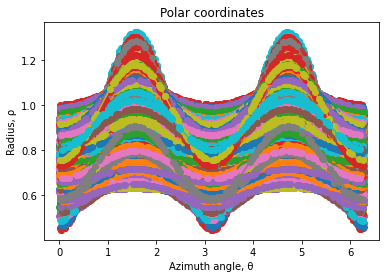

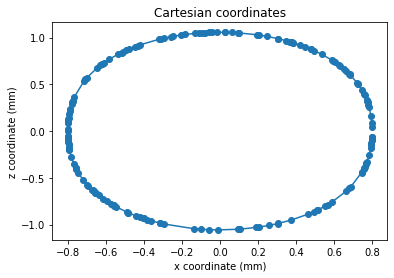

In [ ]:

n=0

plt.figure()
plt.title('Polar coordinates')
for n in range(1000):
  plt.plot(dataset.iloc[n, 175:350], dataset.iloc[n, 0:175], '-o')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')


x, y=pol2cart(dataset.iloc[n, 0:175].values, dataset.iloc[n, 175:350].values)


plt.figure()
plt.title('Cartesian coordinates')
plt.plot(x, y, '-o')
plt.xlabel('x coordinate (mm)')
plt.ylabel('z coordinate (mm)')



### Adding noise 



#### To acoustic pressure

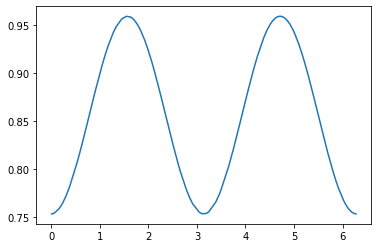

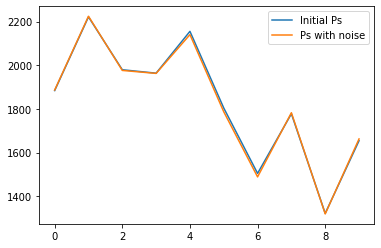

In [ ]:
noisy_dataset=dataset.copy()

np.random.seed(seed=1)
noise1 = np.random.random(size=[len(dataset), ])*25
noise2=np.random.random(size=[len(dataset), ])*25
noisy_dataset.Ps=noisy_dataset.Ps+noise1-noise2

plt.figure()
plt.plot(dataset.iloc[0, 0:sampling], dataset.iloc[0, sampling:sampling*2])

plt.figure()
plt.plot(dataset.Ps[0:10], label='Initial Ps')
plt.plot(noisy_dataset.Ps[0:10], label='Ps with noise')
plt.legend()

#### To ST

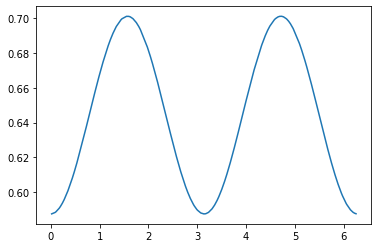

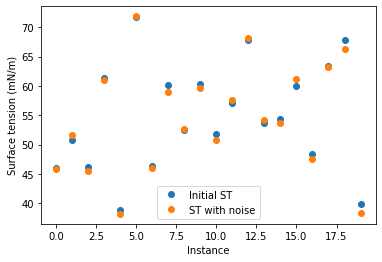

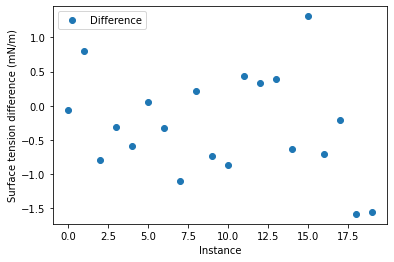

In [ ]:
noisy_dataset=dataset.copy()

np.random.seed(seed=1)
noise1 = np.random.random(size=[len(dataset), ])*2
noise2=np.random.random(size=[len(dataset), ])*2
noisy_dataset.ST=noisy_dataset.ST+noise1-noise2

plt.figure()
plt.plot(dataset.iloc[0, sampling:sampling*2], dataset.iloc[0, 0:sampling])

plt.figure()
plt.plot(dataset.ST[0:20], 'o', label='Initial ST')
plt.plot(noisy_dataset.ST[0:20], 'o', label='ST with noise')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')
plt.legend()

plt.figure()
plt.plot(noisy_dataset.ST[0:20]-dataset.ST[0:20], 'o', label='Difference')
plt.xlabel('Instance')
plt.ylabel('Surface tension difference (mN/m)')
plt.legend()

#### Save the noise dataset

In [ ]:
#The original dataset is on: raw_dataset.tail()
# dataset=raw_dataset
#Save the noisy dataset as dataset
dataset=noisy_dataset.copy()
dataset.tail()

,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,...,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,theta,vol,Ps,ST
49995,0.769955,0.770697,0.771015,0.776379,0.782352,0.784597,0.786373,0.788958,0.789436,0.805315,0.827363,0.828521,0.831590,0.833441,0.844612,0.845183,0.886958,0.886974,0.888134,0.889240,0.897181,0.905043,0.910937,0.920526,0.935758,0.963128,0.977860,0.986319,0.991945,0.997989,1.005684,1.007431,1.010972,1.019495,1.033733,1.076026,1.082972,1.091499,1.095921,1.098607,...,5.233004,5.242322,5.322742,5.333836,5.358181,5.373785,5.403396,5.437367,5.452760,5.470141,5.474240,5.484448,5.505969,5.577914,5.618597,5.644451,5.701744,5.702784,5.721982,5.730067,5.758448,5.803562,5.846485,5.862451,5.874571,5.888006,5.932525,5.948961,5.951301,6.035272,6.038860,6.085891,6.102256,6.108532,6.219703,6.253468,6.269021,4.122496,2949.759108,61.338048
49996,0.910290,0.910332,0.910342,0.910568,0.912532,0.913510,0.914056,0.915070,0.915496,0.920794,0.922659,0.931632,0.934234,0.935204,0.938501,0.940863,0.947361,0.949331,0.949404,0.967056,0.971981,0.972188,0.976915,0.997527,0.997569,0.999382,1.002583,1.030621,1.032040,1.034725,1.038209,1.040127,1.042091,1.042372,1.046991,1.050937,1.054166,1.056911,1.057223,1.057570,...,4.910898,4.996901,5.022119,5.169784,5.179328,5.242008,5.454634,5.459680,5.460495,5.502913,5.597333,5.659587,5.729177,5.776700,5.790093,5.803805,5.852164,5.886311,5.888862,5.899767,5.930305,5.936660,5.940499,5.999136,6.007672,6.032659,6.057659,6.062430,6.067571,6.152387,6.157602,6.161447,6.169635,6.183506,6.229720,6.263364,6.270704,4.304270,1743.073514,50.960358
49997,0.586644,0.586776,0.586795,0.586901,0.587003,0.587587,0.591613,0.594711,0.597562,0.603858,0.605395,0.610209,0.620001,0.625687,0.626209,0.636987,0.640421,0.642318,0.646872,0.648170,0.650649,0.658559,0.661689,0.661790,0.666491,0.668950,0.670898,0.670932,0.672066,0.678887,0.685104,0.687331,0.688200,0.688923,0.691293,0.696127,0.696388,0.698145,0.701267,0.701424,...,5.108276,5.127739,5.227892,5.257026,5.270807,5.303375,5.332903,5.366171,5.405994,5.407792,5.409818,5.413021,5.451912,5.519271,5.543495,5.543712,5.566138,5.672679,5.689355,5.691150,5.694272,5.711496,5.721450,5.770779,5.787785,5.832358,5.842174,5.951822,5.955853,5.989454,6.056776,6.075804,6.086306,6.091723,6.149270,6.158542,6.278975,1.236705,2652.605001,48.681920
49998,0.644898,0.646495,0.648373,0.649100,0.651215,0.651268,0.651305,0.651601,0.651936,0.653408,0.654607,0.655012,0.655019,0.657257,0.659747,0.660921,0.663111,0.663552,0.664577,0.665603,0.665701,0.668933,0.670990,0.673819,0.673942,0.674585,0.674749,0.675051,0.677482,0.677718,0.678418,0.680482,0.681092,0.681226,0.682003,0.682094,0.682816,0.683787,0.683792,0.684316,...,4.791252,4.806562,4.933062,5.015943,5.020122,5.128187,5.135035,5.156354,5.166225,5.212851,5.227481,5.240392,5.245343,5.322665,5.343934,5.422659,5.493397,5.511559,5.512171,5.525491,5.591924,5.597788,5.604130,5.622519,5.783490,5.796063,5.867751,5.890577,5.895930,6.027386,6.031562,6.039119,6.111923,6.164214,6.197428,6.205821,6.229579,1.267398,1603.639302,53.421673
49999,0.592004,0.593309,0.593520,0.594089,0.594366,0.594452,0.595602,0.599017,0.600305,0.602857,0.603192,0.604647,0.606356,0.609111,0.611722,0.612152,0.618323,0.623819,0.626364,0.632660,0.637612,0.640900,0.645028,0.646308,0.649565,0.660481,0.668609,0.668941,0.670443,0.670822,0.672936,0.676517,0.677665,0.679043,0.679055,0.680717,0.680768,0.681716,0.682287,0.682819,...,4.758974,4.808215,4.853784,4.900183,4.901307,4.925324,4.996934,5.084057,5.118733,5.126677,5.204361,5.255058,5.285198,5.319554,5.342053,5.373407,5.553076,5.560371,5.564270,5.577858,5.579047,5.655629,5.670338,5.803566,5.946857,5.996128,6.030702,6.035705,6.052609,6.120562,6.128383,6.158242,6.169614,

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [ ]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [ ]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop("ST")

train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
theta,12111.0,6.176460,0.061702,5.805734,6.143099,6.188445,6.222002,6.281597
theta,12111.0,6.211878,0.051033,5.870475,6.187554,6.224307,6.249231,6.282649
theta,12111.0,6.247768,0.035573,5.968988,6.234369,6.259114,6.272928,6.283181
vol,12111.0,3.689131,1.222589,1.566043,2.633504,3.697234,4.742593,5.804045
volt,12111.0,8.289536,0.982819,6.600000,7.439921,8.296474,9.132068,9.999467


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [ ]:
train_labels = train_dataset.pop('ST')
test_labels = test_dataset.pop('ST')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

### Try to find outilers

In [ ]:
stats=dataset.describe()

stats=stats.transpose()

stats

,count,mean,std,min,25%,50%,75%,max
rho_1,39789.0,0.996714,0.114326,0.643309,0.925719,1.001376,1.078655,1.294062
rho_3,39789.0,0.996448,0.114172,0.644808,0.925971,1.001013,1.078289,1.290918
rho_5,39789.0,0.995628,0.113972,0.644785,0.924881,1.000651,1.077659,1.289553
rho_7,39789.0,0.994079,0.113791,0.641407,0.922694,0.999631,1.077082,1.286506
rho_9,39789.0,0.991968,0.113814,0.638240,0.920107,0.998127,1.075925,1.274855
...,...,...,...,...,...,...,...,...
volume,39789.0,3.397619,1.029448,0.931362,2.680318,3.334763,4.115682,6.006597
R_sph,39789.0,0.922406,0.098161,0.605820,0.861719,0.926813,0.994148,1.127665
volt,39789.0,8.326581,0.896270,6.600000,7.540000,8.340000,9.070000,10.000000
Aspect_Ratio,39789.0,1.261609,0.086947,1.092391,1.191136,1.249412,1.323699,1.547753


#### IQR method

In [ ]:
# IQR = Q3 −  Q1

Q1_Ar=stats.iloc[353, 4]
Q2_Ar=stats.iloc[353, 5]
Q3_Ar=stats.iloc[353, 6]
IQR_Ar=Q3_Ar-Q1_Ar

Low_AR=Q1_Ar-1.5*IQR_Ar
High_AR=Q3_Ar+1.5*IQR_Ar

print('High IQR value: %.5f, Max AR value: %.5f' %(High_AR, max(dataset.Aspect_Ratio)))
print('Low IQR value: %.5f, Min AR value: %.5f' %(Low_AR, min(dataset.Aspect_Ratio)))

High IQR value: 1.52254, Max AR value: 1.54775
Low IQR value: 0.99229, Min AR value: 1.09239


In [ ]:
clearer_df=dataset.drop(dataset[dataset.Aspect_Ratio >= High_AR].index)


In [ ]:
stats=clearer_df.describe()

stats=stats.transpose()


In [ ]:
Q1_vol=stats.iloc[350, 4]
Q2_vol=stats.iloc[350, 5]
Q3_vol=stats.iloc[350, 6]
IQR_vol=Q3_vol-Q1_vol

Low_vol=Q1_vol-1.5*IQR_vol
High_vol=Q3_vol+1.5*IQR_vol

print('High IQR value: %.5f, Max volume value: %.5f' %(High_vol, max(dataset.volume)))
print('Low IQR value: %.5f, Min volume value: %.5f' %(Low_vol, min(dataset.volume)))


High IQR value: 6.30008, Max volume value: 6.00660
Low IQR value: 0.51608, Min volume value: 0.93136


In [ ]:
Q1_volt=stats.iloc[352, 4]
Q2_volt=stats.iloc[352, 5]
Q3_volt=stats.iloc[352, 6]
IQR_volt=Q3_volt-Q1_volt

Low_volt=Q1_volt-1.5*IQR_volt
High_volt=Q3_volt+1.5*IQR_volt

print('High IQR value: %.5f, Max voltage value: %.5f' %(High_volt, max(dataset.volt)))
print('Low IQR value: %.5f, Min voltage value: %.5f' %(Low_volt, min(dataset.volt)))


High IQR value: 11.38000, Max voltage value: 10.00000
Low IQR value: 5.22000, Min voltage value: 6.60000


In [ ]:
Q1_Rsph=stats.iloc[351, 4]
Q2_Rsph=stats.iloc[351, 5]
Q3_Rsph=stats.iloc[351, 6]
IQR_Rsph=Q3_Rsph-Q1_Rsph

Low_Rsph=Q1_Rsph-1.5*IQR_Rsph
High_Rsph=Q3_Rsph+1.5*IQR_Rsph

print('High IQR value: %.5f, Max Rsph value: %.5f' %(High_Rsph, max(dataset.R_sph)))
print('Low IQR value: %.5f, Min Rsph value: %.5f' %(Low_Rsph, min(dataset.R_sph)))


High IQR value: 1.19512, Max Rsph value: 1.12766
Low IQR value: 0.66249, Min Rsph value: 0.60582


In [ ]:
clearer_df[clearer_df.R_sph <= Low_Rsph].index

Int64Index([36431, 36432, 36433, 36434, 36439, 36440, 36441, 36445, 36451,
            36452,
            ...
            36886, 36887, 36888, 36889, 36890, 36891, 36892, 36893, 36894,
            36895],
           dtype='int64', length=447)

In [ ]:
clearerer_df=clearer_df.drop(clearer_df[clearer_df.R_sph <= Low_Rsph].index)


In [ ]:
dataset=clearerer_df.copy()
dataset.reset_index()
dataset.pop('R_sph')
dataset.pop('Aspect_Ratio')

dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
40134,0.823070,0.825227,0.824092,0.818078,0.815634,0.813586,0.808581,0.805554,0.781719,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.688479,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.628819,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.920926,-0.924124,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,8.92,38.500904
40135,0.823070,0.821416,0.820293,0.818078,0.811903,0.809883,0.808581,0.801922,0.778296,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.685423,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.625050,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.910221,-0.917701,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,8.92,38.499712
40136,0.822786,0.823070,0.823852,0.822457,0.822217,0.818713,0.814799,0.807522,0.803189,0.799657,0.794785,0.764862,0.753192,0.745215,0.742796,0.706155,0.694930,0.689382,0.674743,0.667122,0.653507,0.650905,0.638653,0.635265,0.634700,0.627852,0.628819,0.623878,0.622282,0.624406,0.623456,0.621623,0.622646,0.624816,0.624101,0.628132,0.629016,0.632727,0.635035,0.638527,...,-0.757954,-0.808650,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,8.92,38.503163
40137,0.817186,0.817902,0.815699,0.814972,0.811311,0.807171,0.803610,0.804156,0.794612,0.775011,0.761904,0.758179,0.732146,0.715399,0.707627,0.691228,0.682313,0.673345,0.664653,0.654785,0.649896,0.645412,0.644084,0.638701,0.636487,0.632267,0.634242,0.628821,0.627307,0.627517,0.628333,0.628368,0.629902,0.632914,0.631978,0.634991,0.639480,0.638094,0.640839,0.646340,...,-0.841003,-0.915101,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,8.92,38.493602
40138,0.817338,0.818125,0.816030,0.811797,0.808375,0.808049,0.804638,0.801596,0.792391,0.770040,0.758632,0.754950,0.729203,0.712674,0.705017,0.688896,0.680123,0.671387,0.662890,0.653219,0.648498,0.644141,0.642902,0.637784,0.635728,0.631642,0.633688,0.628565,0.627354,0.627634,0.6

### Min-Max transformation

#### Trial

In [792]:
dataset.pop('R_sph')
dataset.pop('Aspect_Ratio')
dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
3222,0.823070,0.825227,0.824092,0.818078,0.815634,0.813586,0.808581,0.805554,0.781719,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.688479,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.628819,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.920926,-0.924124,-0.956637,-0.971200,-0.978452,-0.988549,-1.017115,-1.024199,-1.079945,-1.151564,-1.158102,-1.216600,-1.222858,-1.233662,-1.239844,-1.244438,-1.261278,-1.265890,-1.282570,-1.309578,-1.335066,-1.350062,-1.355728,-1.410284,-1.429563,-1.434211,-1.462728,-1.472522,-1.481830,-1.486882,-1.500817,-1.514780,-1.542897,-1.552194,-1.556844,-1.561494,-1.570796,1.764766,8.92,38.500904
3223,0.823070,0.821416,0.820293,0.818078,0.811903,0.809883,0.808581,0.801922,0.778296,0.769040,0.762256,0.758620,0.722741,0.711439,0.704215,0.685423,0.679033,0.671057,0.662158,0.652095,0.647050,0.642455,0.641053,0.635461,0.633131,0.628819,0.630747,0.629632,0.625143,0.623468,0.624406,0.624336,0.625845,0.625050,0.628609,0.629899,0.632727,0.637426,0.642080,0.648405,...,-0.910221,-0.917701,-0.950547,-0.960931,-0.968239,-0.982794,-1.007249,-1.014392,-1.077545,-1.149534,-1.156107,-1.214898,-1.221189,-1.232046,-1.238260,-1.242873,-1.259798,-1.264429,-1.281194,-1.308337,-1.333948,-1.349015,-1.354711,-1.409530,-1.428899,-1.433569,-1.462728,-1.472062,-1.481830,-1.486490,-1.500490,-1.514780,-1.542766,-1.552194,-1.556844,-1.561494,-1.570796,1.762896,8.92,38.499712
3224,0.822786,0.823070,0.823852,0.822457,0.822217,0.818713,0.814799,0.807522,0.803189,0.799657,0.794785,0.764862,0.753192,0.745215,0.742796,0.706155,0.694930,0.689382,0.674743,0.667122,0.653507,0.650905,0.638653,0.635265,0.634700,0.627852,0.628819,0.623878,0.622282,0.624406,0.623456,0.621623,0.622646,0.624816,0.624101,0.628132,0.629016,0.632727,0.635035,0.638527,...,-0.757954,-0.808650,-0.861586,-0.887701,-0.902728,-0.913481,-0.992894,-1.017115,-1.024199,-1.038292,-1.045301,-1.059240,-1.086790,-1.093606,-1.151564,-1.216600,-1.276562,-1.282570,-1.293157,-1.299080,-1.303703,-1.320031,-1.324659,-1.339706,-1.365013,-1.390097,-1.404872,-1.409530,-1.462728,-1.481830,-1.486490,-1.514780,-1.524101,-1.533604,-1.538250,-1.552194,-1.566145,1.768315,8.92,38.503163
3225,0.817186,0.817902,0.815699,0.814972,0.811311,0.807171,0.803610,0.804156,0.794612,0.775011,0.761904,0.758179,0.732146,0.715399,0.707627,0.691228,0.682313,0.673345,0.664653,0.654785,0.649896,0.645412,0.644084,0.638701,0.636487,0.632267,0.634242,0.628821,0.627307,0.627517,0.628333,0.628368,0.629902,0.632914,0.631978,0.634991,0.639480,0.638094,0.640839,0.646340,...,-0.841003,-0.915101,-0.940452,-0.947797,-0.962433,-0.969723,-0.979906,-1.008631,-1.015757,-1.071856,-1.143962,-1.209439,-1.214041,-1.226621,-1.231232,-1.237463,-1.254426,-1.259053,-1.275859,-1.301789,-1.328725,-1.343818,-1.348488,-1.403695,-1.423197,-1.428565,-1.457272,-1.467150,-1.476514,-1.481202,-1.495644,-1.509696,-1.538021,-1.547381,-1.552063,-1.556746,-1.566113,1.753342,8.92,38.493602
3226,0.817338,0.818125,0.816030,0.811797,0.808375,0.808049,0.804638,0.801596,0.792391,0.770040,0.758632,0.754950,0.729203,0.712674,0.705017,0.688896,0.680123,0.671387,0.662890,0.653219,0.648498,0.644141,0.642902,0.637784,0.635728,0.631642,0.633688,0.628565,0.627354,0.627634,0.628565

In [793]:
points=175

stats = dataset.iloc[:, points*2:].describe()
stats.pop("ST")

stats = stats.transpose()
stats

,count,mean,std,min,25%,50%,75%,max
volume,3227.0,1.997205,0.655108,0.931362,1.455594,1.921257,2.510701,3.280475
volt,3227.0,7.803474,0.714712,6.600000,7.180000,7.840000,8.450000,9.000000


In [794]:
max_rho=[]
min_rho=[]
min_theta=[]
max_theta=[]
for i in range(len(dataset)):
  max_rho.append(max(dataset.iloc[i, 0:175].values))
  min_rho.append(min(dataset.iloc[i, 0:175].values))
  max_theta.append(max(dataset.iloc[i, 175:350].values))
  min_theta.append(min(dataset.iloc[i, 175:350].values))

print(min(min_rho), max(max_rho), min(min_theta), max(max_theta))

0.5242813548781032 1.0219602591822603 -3.1392452400611175 3.1415926535897927


##### Combination

In [ ]:
max_rho=[]
min_rho=[]
min_theta_exp=[]
max_theta_exp=[]
min_theta_theo=[]
max_theta_theo=[]
for i in range(len(dataset)):
  max_rho.append(max(dataset.iloc[i, 0:175].values))
  min_rho.append(min(dataset.iloc[i, 0:175].values))
  if i <len(dataset)/2:
    max_theta_exp.append(max(dataset.iloc[i, 175:350].values))
    min_theta_exp.append(min(dataset.iloc[i, 175:350].values))
  else:
    max_theta_theo.append(max(dataset.iloc[i, 175:350].values))
    min_theta_theo.append(min(dataset.iloc[i, 175:350].values))

print(min(min_rho), max(max_rho), min(min_theta_exp), max(max_theta_exp),  min(min_theta_theo), max(max_theta_theo))

0.5629049093298075 1.3812261349232764 -3.1396584200251643 3.1415926535897927 1.4839342762442012e-06 6.283184930343791


In [ ]:
# Change the range of rho from 0 to 1

OldMax= max(max_rho)
OldMin=min(min_rho)

NewValues_rho={}

OldRange = (OldMax - OldMin)
for i in range(len(dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, 0:175] - OldMin)/(OldMax-OldMin) 
      NewValues_rho[i]=NewValue

In [ ]:
# Change the range of theta from 0 to 1

OldMax= max(max_theta_exp)
OldMin=min(min_theta_exp)

NewValues_theta_exp={}

OldRange = (OldMax - OldMin)
for i in range(int(len(dataset)/2)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, 175:350] - OldMin)/(OldMax-OldMin) 
      NewValues_theta_exp[i]=NewValue

In [ ]:
# Change the range of theta from 0 to 1

OldMax= max(max_theta_theo)
OldMin=min(min_theta_theo)

NewValues_theta_theo={}

OldRange = (OldMax - OldMin)
for i in range(int(len(dataset)/2), int(len(dataset))):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, 175:350] - OldMin)/(OldMax-OldMin) 
      NewValues_theta_theo[i]=NewValue

In [ ]:
df_rho=pd.DataFrame.from_dict(NewValues_rho).T
df_theta_exp=pd.DataFrame.from_dict(NewValues_theta_exp).T
df_theta_theo=pd.DataFrame.from_dict(NewValues_theta_theo).T

df_theta=pd.concat([df_theta_exp, df_theta_theo], axis=0)
new_df=pd.concat([df_rho, df_theta], axis=1)

new_df.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_260,theta_261,theta_262,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299
30273,0.216479,0.216511,0.216676,0.219573,0.228078,0.228917,0.247513,0.248458,0.249361,0.252402,0.266197,0.266464,0.270765,0.281712,0.303804,0.308762,0.315060,0.315231,0.320782,0.328170,0.328207,0.344125,0.374063,0.382015,0.403821,0.416825,0.423561,0.428216,0.429648,0.439375,0.445185,0.452021,0.457870,0.459714,0.464203,0.471153,0.505403,0.505445,0.513522,0.514210,...,0.760997,0.762864,0.768956,0.770490,0.770729,0.783803,0.786546,0.792157,0.794754,0.806850,0.811007,0.812153,0.815573,0.820555,0.826134,0.827602,0.852032,0.854670,0.857491,0.865017,0.896632,0.898630,0.899723,0.917887,0.921320,0.933838,0.937396,0.947965,0.949381,0.951904,0.958289,0.967586,0.969355,0.974333,0.981654,0.984500,0.984986,0.994612,0.995382,0.999637
30274,0.054795,0.084223,0.101937,0.105362,0.106487,0.112778,0.115451,0.127420,0.128769,0.138403,0.144091,0.164265,0.172976,0.183243,0.183958,0.200889,0.202513,0.224213,0.240907,0.264438,0.269902,0.314218,0.322203,0.382871,0.393019,0.411627,0.437452,0.453975,0.472188,0.489641,0.502474,0.509256,0.514203,0.536254,0.546409,0.563478,0.571665,0.576606,0.591485,0.595598,...,0.794602,0.797863,0.799816,0.811669,0.833676,0.839815,0.839944,0.845839,0.852639,0.855882,0.863841,0.866952,0.871977,0.873364,0.882053,0.884243,0.884917,0.898291,0.899406,0.903997,0.904797,0.910938,0.921870,0.923974,0.932025,0.938005,0.942411,0.956837,0.957162,0.960947,0.960957,0.969419,0.970773,0.974599,0.975545,0.977896,0.977997,0.981869,0.983912,0.989850
30275,0.441204,0.444184,0.445746,0.452727,0.452851,0.454355,0.460458,0.468356,0.468862,0.472147,0.473106,0.479321,0.479444,0.492155,0.494586,0.494613,0.496172,0.501731,0.511490,0.513042,0.518565,0.519116,0.529810,0.538741,0.549961,0.558687,0.561817,0.566229,0.590808,0.595880,0.597188,0.598312,0.615272,0.628964,0.636024,0.643659,0.648681,0.649599,0.655740,0.656900,...,0.736762,0.739121,0.740488,0.749178,0.757629,0.759813,0.760943,0.761643,0.781632,0.789998,0.805227,0.805928,0.805981,0.812377,0.821181,0.824903,0.829045,0.836717,0.837834,0.840426,0.847195,0.864457,0.864934,0.870234,0.878426,0.881134,0.891553,0.894417,0.895449,0.897532,0.903269,0.908686,0.916040,0.918396,0.940171,0.952032,0.971683,0.978799,0.988676,0.997597
30276,0.207986,0.208242,0.209803,0.210689,0.211417,0.216335,0.219008,0.222189,0.226934,0.228985,0.238917,0.242078,0.242728,0.246205,0.248835,0.270188,0.281083,0.302502,0.304134,0.327497,0.333683,0.336151,0.344578,0.350653,0.351599,0.375546,0.385791,0.396982,0.400662,0.407559,0.425694,0.443301,0.458578,0.460874,0.464245,0.465815,0.478455,0.496326,0.499501,0.508660,...,0.765028,0.769125,0.772365,0.781105,0.783757,0.789479,0.795700,0.807478,0.808278,0.808573,0.817646,0.818844,0.824056,0.829341,0.831739,0.840341,0.850447,0.852543,0.868700,0.876121,0.878983,0.882124,0.885186,0.913683,0.919343,0.922241,0.925672,0.926219,0.931178,0.936433,0.944188,0.950331,0.967019,0.968183,0.969555,0.975894,0.976651,0.983923,0.991015,0.992420
30277,0.450247,0.450320,0.450509,0.451126,0.451212,0.452061,0.452398,0.452616,0.455789,0.459038,0.461567,0.464573,0.472564,0.479012,0.481199,0.485683,0.523699,0.530569,0.550162,0.552156,0.554205,0.557397,0.582823,0.583140,0.589454,0.602797,0.607584,0.615952,0.626906,0.626953,0.627253,0.628754,0.634068,0.658234,0.663164,0.668236,0.672737,0.675890,0.694569,0.702053,...,0.746440,0.756318,0.762956,0.7

Text(0.5, 0, 'Azimuth angle, θ')

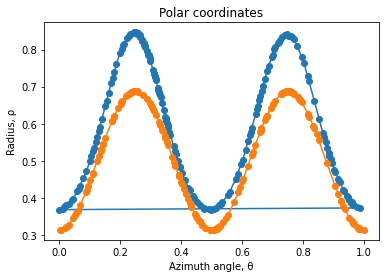

In [ ]:
n=0
k=int(len(dataset)/2)+5
plt.figure()
plt.title('Polar coordinates')
plt.plot(new_df.iloc[n, 175:350], new_df.iloc[n, 0:175], '-o')
plt.plot(new_df.iloc[k, 175:350], new_df.iloc[k, 0:175], '-o')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')

#### Else

In [795]:
# Change the range of rho from 0 to 1

OldMax= max(max_rho)
OldMin=min(min_rho)

NewValues_rho={}

OldRange = (OldMax - OldMin)
for i in range(len(dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, 0:175] - OldMin)/(OldMax-OldMin) 
      NewValues_rho[i]=NewValue

In [796]:
# Change the range of theta from 0 to 1

OldMax= max(max_theta)
OldMin=min(min_theta)

NewValues_theta={}

OldRange = (OldMax - OldMin)
for i in range(len(dataset)):
  if (OldRange == 0):
      NewValue = NewMin
      NewValues.append(NewValue)
  else:
      NewValue = (dataset.iloc[i, 175:350] - OldMin)/(OldMax-OldMin) 
      NewValues_theta[i]=NewValue

In [797]:
df_rho=pd.DataFrame.from_dict(NewValues_rho).T
df_theta=pd.DataFrame.from_dict(NewValues_theta).T

new_df=pd.concat([df_rho, df_theta], axis=1)

new_df.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_260,theta_261,theta_262,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299
3222,0.600365,0.604699,0.602417,0.590335,0.585422,0.581309,0.571251,0.565168,0.517276,0.491800,0.478170,0.470864,0.398771,0.376061,0.361546,0.329927,0.310946,0.294921,0.277040,0.256820,0.246683,0.237450,0.234633,0.223396,0.218715,0.210049,0.213924,0.211685,0.202665,0.199298,0.201183,0.201042,0.204075,0.210049,0.209629,0.212221,0.217902,0.227345,0.236695,0.249406,...,0.372298,0.370464,0.368008,0.353188,0.352679,0.347503,0.345184,0.344029,0.342422,0.337874,0.336746,0.327870,0.316468,0.315427,0.306113,0.305117,0.303396,0.302412,0.301681,0.299000,0.298265,0.295610,0.291309,0.287251,0.284864,0.283962,0.275276,0.272206,0.271466,0.266926,0.265366,0.263884,0.263080,0.260861,0.258638,0.254162,0.252681,0.251941,0.251201,0.249720
3223,0.600365,0.597040,0.594784,0.590335,0.577927,0.573867,0.571251,0.557872,0.510398,0.491800,0.478170,0.470864,0.398771,0.376061,0.361546,0.323787,0.310946,0.294921,0.277040,0.256820,0.246683,0.237450,0.234633,0.223396,0.218715,0.210049,0.213924,0.211685,0.202665,0.199298,0.201183,0.201042,0.204075,0.202477,0.209629,0.212221,0.217902,0.227345,0.236695,0.249406,...,0.373523,0.371669,0.369831,0.354893,0.353702,0.348472,0.346819,0.345656,0.343338,0.339445,0.338307,0.328252,0.316791,0.315744,0.306384,0.305382,0.303654,0.302664,0.301930,0.299235,0.298498,0.295829,0.291507,0.287429,0.285030,0.284124,0.275396,0.272312,0.271568,0.266926,0.265440,0.263884,0.263143,0.260913,0.258638,0.254182,0.252681,0.251941,0.251201,0.249720
3224,0.599794,0.600365,0.601936,0.599133,0.598650,0.591610,0.583746,0.569123,0.560418,0.553320,0.543530,0.483406,0.459956,0.443928,0.439068,0.365444,0.342889,0.331741,0.302326,0.287013,0.259657,0.254428,0.229809,0.223002,0.221868,0.208108,0.210049,0.200123,0.196915,0.201183,0.199275,0.195592,0.197647,0.202007,0.200571,0.208670,0.210447,0.217902,0.222539,0.229556,...,0.387476,0.383603,0.381684,0.379136,0.371064,0.362636,0.358478,0.356086,0.354374,0.341730,0.337874,0.336746,0.334502,0.333386,0.331167,0.326781,0.325695,0.316468,0.306113,0.296566,0.295610,0.293924,0.292981,0.292245,0.289645,0.288908,0.286513,0.282483,0.278490,0.276137,0.275396,0.266926,0.263884,0.263143,0.258638,0.257154,0.255641,0.254902,0.252681,0.250460
3225,0.588541,0.589980,0.585553,0.584093,0.576736,0.568418,0.561264,0.562361,0.543184,0.503798,0.477461,0.469977,0.417668,0.384018,0.368401,0.335451,0.317538,0.299519,0.282052,0.262224,0.252400,0.243391,0.240724,0.229907,0.225458,0.216978,0.220947,0.210055,0.207013,0.207435,0.209073,0.209143,0.212227,0.218279,0.216397,0.222453,0.231471,0.228687,0.234203,0.245257,...,0.373839,0.370166,0.367715,0.365913,0.354116,0.350080,0.348910,0.346580,0.345419,0.343798,0.339224,0.338090,0.329158,0.317678,0.307253,0.306520,0.304517,0.303783,0.302791,0.300090,0.299354,0.296678,0.292549,0.288261,0.285858,0.285114,0.276325,0.273220,0.272365,0.267794,0.266222,0.264731,0.263984,0.261685,0.259448,0.254938,0.253448,0.252702,0.251957,0.250465
3226,0.588847,0.590429,0.586220,0.577714,0.570838,0.570183,0.563329,0.557217,0.538719,0.493810,0.470888,0.463489,0.411754,0.378543,0.363157,0.330765,0.313136,0.295584,0.278509,0.259078,0.249593,0.240838,0.238348,0.228065,0.223933,0.215722,0.219834,0.209541,0.207107,0.207669,0.209541,0.210125,0.213347,0.212064,0.217931,0.224349,0.233722,0.231034,0.236907,0.248119,...,0.373227,0.368940,0.367132,0.364695

Text(0.5, 0, 'Azimuth angle, θ')

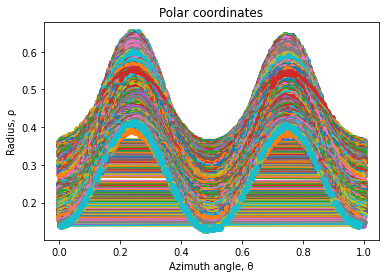

In [798]:
plt.figure()
plt.title('Polar coordinates')
for n in range(1000):
  plt.plot(new_df.iloc[n, 175:350], new_df.iloc[n, 0:175], '-o')
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')

#### Continue from here

In [799]:
def min_max_norm(x):
  return (x-stats['min'])/(stats['max']-stats['min'])

normed_data_rest = min_max_norm(dataset.iloc[:, points*2:])


In [800]:
normed_data = new_df.copy()
normed_data['volume'] = normed_data_rest.volume
# normed_data['Ps'] = normed_data_rest.Ps
normed_data['volt'] = normed_data_rest.volt
normed_data['ST'] = dataset.ST

normed_data.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
3222,0.600365,0.604699,0.602417,0.590335,0.585422,0.581309,0.571251,0.565168,0.517276,0.491800,0.478170,0.470864,0.398771,0.376061,0.361546,0.329927,0.310946,0.294921,0.277040,0.256820,0.246683,0.237450,0.234633,0.223396,0.218715,0.210049,0.213924,0.211685,0.202665,0.199298,0.201183,0.201042,0.204075,0.210049,0.209629,0.212221,0.217902,0.227345,0.236695,0.249406,...,0.353188,0.352679,0.347503,0.345184,0.344029,0.342422,0.337874,0.336746,0.327870,0.316468,0.315427,0.306113,0.305117,0.303396,0.302412,0.301681,0.299000,0.298265,0.295610,0.291309,0.287251,0.284864,0.283962,0.275276,0.272206,0.271466,0.266926,0.265366,0.263884,0.263080,0.260861,0.258638,0.254162,0.252681,0.251941,0.251201,0.249720,0.354774,0.966667,38.500904
3223,0.600365,0.597040,0.594784,0.590335,0.577927,0.573867,0.571251,0.557872,0.510398,0.491800,0.478170,0.470864,0.398771,0.376061,0.361546,0.323787,0.310946,0.294921,0.277040,0.256820,0.246683,0.237450,0.234633,0.223396,0.218715,0.210049,0.213924,0.211685,0.202665,0.199298,0.201183,0.201042,0.204075,0.202477,0.209629,0.212221,0.217902,0.227345,0.236695,0.249406,...,0.354893,0.353702,0.348472,0.346819,0.345656,0.343338,0.339445,0.338307,0.328252,0.316791,0.315744,0.306384,0.305382,0.303654,0.302664,0.301930,0.299235,0.298498,0.295829,0.291507,0.287429,0.285030,0.284124,0.275396,0.272312,0.271568,0.266926,0.265440,0.263884,0.263143,0.260913,0.258638,0.254182,0.252681,0.251941,0.251201,0.249720,0.353978,0.966667,38.499712
3224,0.599794,0.600365,0.601936,0.599133,0.598650,0.591610,0.583746,0.569123,0.560418,0.553320,0.543530,0.483406,0.459956,0.443928,0.439068,0.365444,0.342889,0.331741,0.302326,0.287013,0.259657,0.254428,0.229809,0.223002,0.221868,0.208108,0.210049,0.200123,0.196915,0.201183,0.199275,0.195592,0.197647,0.202007,0.200571,0.208670,0.210447,0.217902,0.222539,0.229556,...,0.379136,0.371064,0.362636,0.358478,0.356086,0.354374,0.341730,0.337874,0.336746,0.334502,0.333386,0.331167,0.326781,0.325695,0.316468,0.306113,0.296566,0.295610,0.293924,0.292981,0.292245,0.289645,0.288908,0.286513,0.282483,0.278490,0.276137,0.275396,0.266926,0.263884,0.263143,0.258638,0.257154,0.255641,0.254902,0.252681,0.250460,0.356285,0.966667,38.503163
3225,0.588541,0.589980,0.585553,0.584093,0.576736,0.568418,0.561264,0.562361,0.543184,0.503798,0.477461,0.469977,0.417668,0.384018,0.368401,0.335451,0.317538,0.299519,0.282052,0.262224,0.252400,0.243391,0.240724,0.229907,0.225458,0.216978,0.220947,0.210055,0.207013,0.207435,0.209073,0.209143,0.212227,0.218279,0.216397,0.222453,0.231471,0.228687,0.234203,0.245257,...,0.365913,0.354116,0.350080,0.348910,0.346580,0.345419,0.343798,0.339224,0.338090,0.329158,0.317678,0.307253,0.306520,0.304517,0.303783,0.302791,0.300090,0.299354,0.296678,0.292549,0.288261,0.285858,0.285114,0.276325,0.273220,0.272365,0.267794,0.266222,0.264731,0.263984,0.261685,0.259448,0.254938,0.253448,0.252702,0.251957,0.250465,0.349911,0.966667,38.493602
3226,0.588847,0.590429,0.586220,0.577714,0.570838,0.570183,0.563329,0.557217,0.538719,0.493810,0.470888,0.463489,0.411754,0.378543,0.363157,0.330765,0.313136,0.295584,0.278509,0.259078,0.249593,0.240838,0.238348,0.228065,0.223933,0.215722,0.219834,0.209541,0.207107,0.207669,0.209541,0.210125,0.213347,0.212064,0.217931,0.224349,0.233722,0.231034,0.236907,0.248119,...,0.364695,0.352933,0.348910,0.347744,0.345419,0

### Shuffle the data

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
763,0.422758,0.426355,0.424617,0.423098,0.417045,0.422098,0.416242,0.408828,0.399610,0.391886,0.383155,0.381304,0.375983,0.341879,0.330061,0.321668,0.297093,0.292669,0.280924,0.269834,0.267310,0.258965,0.260764,0.257749,0.255495,0.245848,0.245439,0.238325,0.243003,0.240472,0.238348,0.237159,0.235327,0.234066,0.237731,0.242115,0.243527,0.242388,0.243914,0.250975,...,0.357494,0.347604,0.335986,0.334796,0.324309,0.323155,0.321235,0.320091,0.318953,0.315918,0.315137,0.314017,0.312118,0.310223,0.303763,0.302685,0.300011,0.299206,0.289131,0.285672,0.284671,0.279589,0.278616,0.277796,0.275193,0.274372,0.272724,0.270961,0.270137,0.265093,0.263440,0.262612,0.261784,0.260071,0.258418,0.252622,0.251793,0.217439,0.104167,41.226564
835,0.404404,0.398435,0.402214,0.395259,0.395055,0.393954,0.391258,0.390522,0.380547,0.378156,0.369341,0.364767,0.356664,0.350998,0.347629,0.317328,0.308249,0.298454,0.280642,0.279091,0.269616,0.263127,0.256831,0.255072,0.250867,0.250414,0.250731,0.241094,0.239359,0.235928,0.242234,0.241550,0.241824,0.234553,0.236386,0.242280,0.241414,0.249871,0.247012,0.251727,...,0.354577,0.352086,0.347137,0.345908,0.335913,0.324122,0.323344,0.313275,0.312145,0.310222,0.309420,0.308303,0.305580,0.304479,0.303668,0.301762,0.299862,0.293384,0.292561,0.289863,0.289035,0.279152,0.275666,0.274829,0.269676,0.268835,0.267897,0.265378,0.264537,0.262782,0.261103,0.260262,0.255208,0.253500,0.252660,0.251831,0.250140,0.201810,0.129167,40.806616
1653,0.975683,0.976324,0.975203,0.970918,0.965440,0.958113,0.945713,0.932313,0.923773,0.903459,0.885706,0.869940,0.855824,0.836999,0.767240,0.755409,0.717726,0.711545,0.633520,0.587282,0.567580,0.544977,0.532587,0.530406,0.522837,0.521618,0.510517,0.502091,0.484966,0.484717,0.479177,0.473811,0.466775,0.464442,0.467707,0.467047,0.468911,0.474236,0.471605,0.475724,...,0.359707,0.355907,0.350260,0.349306,0.345124,0.343244,0.341374,0.341008,0.340080,0.338231,0.337310,0.333653,0.332416,0.327940,0.326474,0.324709,0.321217,0.318046,0.316340,0.313217,0.310954,0.306470,0.304249,0.297682,0.286177,0.285574,0.284234,0.276415,0.272010,0.266433,0.263359,0.259695,0.258489,0.256677,0.255447,0.252433,0.251227,0.984211,0.791667,46.828962
2607,0.730912,0.731574,0.726338,0.722567,0.717555,0.709934,0.694053,0.688009,0.676370,0.666439,0.662124,0.648227,0.617756,0.601186,0.580152,0.538845,0.511229,0.488260,0.460248,0.453071,0.446233,0.431490,0.422193,0.418024,0.404960,0.400417,0.389550,0.382986,0.381895,0.374717,0.375833,0.374345,0.368542,0.368687,0.370866,0.373662,0.373662,0.371757,0.379939,0.380351,...,0.376993,0.373102,0.371450,0.366510,0.364897,0.358952,0.355236,0.353698,0.349443,0.346894,0.344799,0.342714,0.333477,0.331460,0.316086,0.313521,0.312576,0.311636,0.310970,0.309105,0.306841,0.302751,0.301172,0.295582,0.292481,0.288724,0.284990,0.278417,0.276927,0.272704,0.270549,0.267033,0.266345,0.263530,0.261466,0.260730,0.253151,0.598612,0.612500,40.938364
2732,0.752827,0.753122,0.754429,0.747128,0.740457,0.733827,0.724632,0.695189,0.690589,0.677774,0.659579,0.654710,0.632417,0.581981,0.530947,0.476535,0.445529,0.427512,0.386543,0.375797,0.364137,0.339210,0.335111,0.325271,0.313439,0.294182,0.285674,0.270771,0.270838,0.264467,0.260157,0.261977,0.257276,0.254321,0.262224,0.265654,0.263278,0.268293,0.278288,0.284549,...,0.406924,0.399001,0.391323,0.390126,0.383356,0.3

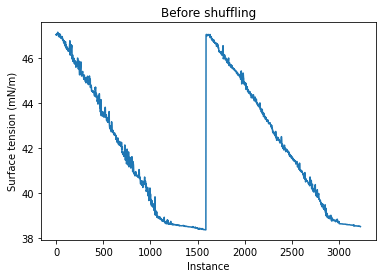

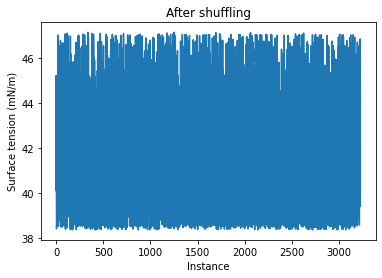

In [801]:
from sklearn.utils import shuffle

plt.figure()
plt.title('Before shuffling')
plt.plot(range(len(normed_data)), normed_data.ST)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')

normed_data=shuffle(normed_data, random_state=0)

plt.figure()
plt.title('After shuffling')
plt.plot(range(len(normed_data)), normed_data.ST)
plt.ylabel('Surface tension (mN/m)')
plt.xlabel('Instance')

normed_data.tail()

### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [802]:
normed_train_data = normed_data.sample(frac=0.8,random_state=0)
normed_test_data = normed_data.drop(normed_train_data.index)

Text(0.5, 0, 'Azimuth angle, θ')

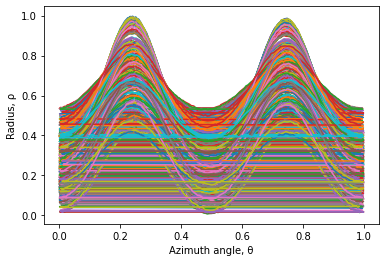

In [309]:
plt.figure()
for i in range(1000):
  plt.plot(normed_train_data.iloc[i, 175:350], normed_train_data.iloc[i, 0:175])
plt.ylabel('Radius, ρ')
plt.xlabel('Azimuth angle, θ')

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [803]:
train_labels = normed_train_data.pop('ST')
test_labels = normed_test_data.pop('ST')

### Standard normalization

In [ ]:
def std_norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = std_norm(train_dataset)
normed_test_data  = std_norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

####Learning Schedule
The code bellow sets a schedules.InverseTimeDecay to hyperbolically decrease the learning rate to 1/2 of the base rate at 1000 epochs, 1/3 at 2000 epochs and so on.

In [ ]:
#Lr_schedule = learning schedule : Most models learn better if you gradually decrase the learning rate.

STEPS_PER_EPOCH=len(train_dataset)/500
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)


Here we can plot the learning rate Vs the number of epocs

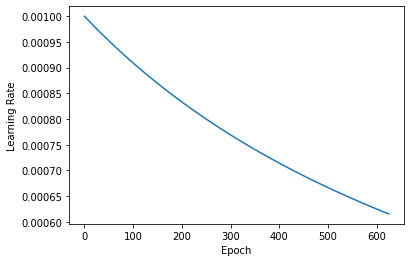

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure()
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([min(plt.ylim()),max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

####Define model

In [777]:
def build_model():
  model = keras.Sequential([
    layers.Dense(40, activation=tf.nn.softplus, input_shape=[len(normed_train_data.keys())]), #kernel_regularizer='l2', 
    # layers.Dense(50, activation=tf.nn.softplus),
    layers.Dense(20, activation=tf.nn.softplus),
    # layers.Dense(5, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

def get_optimizer():
  return tf.keras.optimizers.Adam()

In [804]:
model = build_model()

#### If there is a model saved on google drive execute the next block

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [84]:
from tensorflow.keras.models import load_model

# del model 

folder=str('Experimental_surfactants/')

model_name=str('CTAB_files_7_14_0.37.h5')

model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+folder+model_name))


### Inspect the model

Use the `.summary` method to print a simple description of the model

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                14120     
_________________________________________________________________
dense_1 (Dense)              (None, 20)                820       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 21        
Total params: 14,961
Trainable params: 14,961
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.get_config()

In [ ]:
model.get_weights()


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [36]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.09549385],
       [0.20965241],
       [0.19426583],
       [0.02923233],
       [0.24319062],
       [0.20547199],
       [0.07120322],
       [0.11236899],
       [0.23221615],
       [0.1474541 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [805]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, min_delta=0, restore_best_weights=True)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
............................................................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [806]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
387,1.050979,0.619463,1.050979,1.270596,0.613581,1.270596,387
388,1.051123,0.614284,1.051123,1.264447,0.553131,1.264447,388
389,1.229560,0.710586,1.229560,1.573912,0.703808,1.573912,389
390,1.201954,0.706472,1.201954,1.298607,0.787136,1.298607,390
391,1.142662,0.660691,1.142662,1.153813,0.614675,1.153813,391


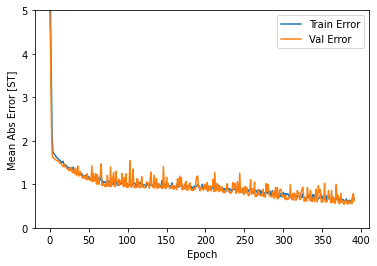

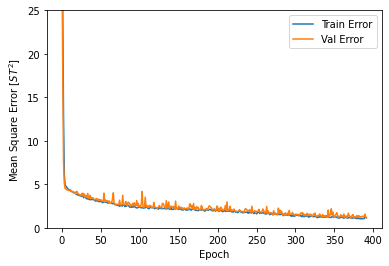

In [807]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,25])
  plt.legend()
  plt.show()


plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [808]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

print("Testing set Mean Abs Error over ST range: {:5.2f}".format(mae/(max(dataset.ST)-min(dataset.ST))))


Testing set Mean Abs Error:  0.59 mN/m
Testing set Mean Abs Error over ST range:  0.07


### Make predictions

Finally, predict ST values using data in the testing set:

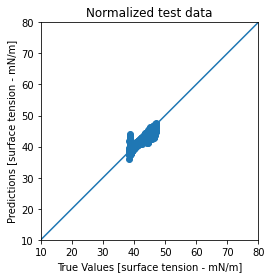

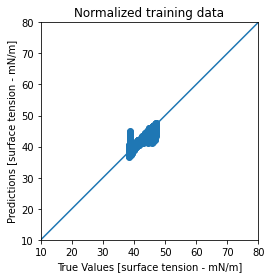

In [809]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

train_predictions = model.predict(normed_train_data).flatten()

plt.scatter(train_labels, train_predictions)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

# plt.figure()
# plt.xlabel('Image')
# plt.ylabel('Surface tension [ mN/m ]')
# plt.ylim(30, 75)
# plt.plot(test_predictions[0:2000], label='Predicted test instances')
# plt.plot(range(len(test_labels)-18000), test_labels[0:2000], '--', label='Real test instances')
# plt.legend()


Seriously?

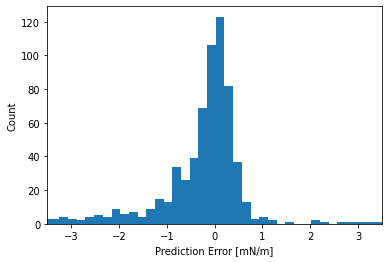

In [812]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
plt.xlim(-3.5, 3.5)
# plt.ylim(0, 10)
plt.show()

Text(0, 0.5, 'Surface tension (mN/m)')

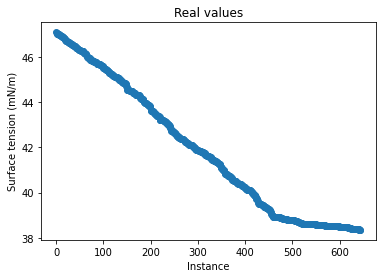

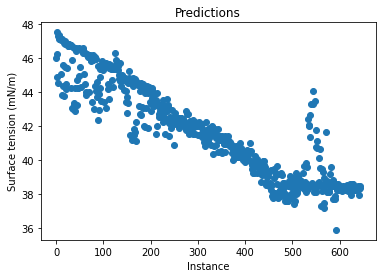

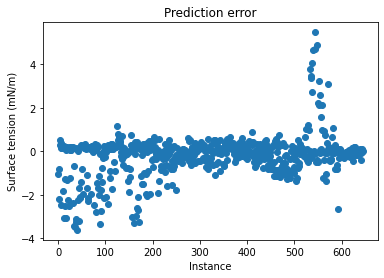

In [811]:

check_test_df=pd.DataFrame(data={'True_values': test_labels, 'Predictions': test_predictions})

sorted_st=check_test_df.sort_values(by=['True_values'], ascending=False)

plt.figure()
plt.title('Real values')
plt.plot(range(len(sorted_st)), sorted_st.True_values, '-o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Predictions')
plt.plot(range(len(sorted_st)), sorted_st.Predictions, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Prediction error')
plt.plot(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

# sorted_st

In [488]:
sorted_st['error']= sorted_st.Predictions-sorted_st.True_values
test_data_drop=sorted_st.loc[(sorted_st['error'] >= 1) | (sorted_st['error']<=-1)]

print(test_data_drop.shape)
test_data_drop


(35, 3)


,True_values,Predictions,error
1695,57.926935,56.591789,-1.335146
1677,57.896660,54.892792,-3.003868
1676,57.890944,54.781025,-3.109919
1686,57.886400,54.904041,-2.982359
1681,57.866882,54.907219,-2.959663
1741,57.646897,56.425701,-1.221196
1758,57.636584,56.526009,-1.110576
1764,57.614667,56.455891,-1.158776
1881,56.918346,55.867256,-1.051089
1893,56.863127,55.752110,-1.111017


### Investigate on the data that are off

In [ ]:
good_df=input.drop(labels=test_data_drop.index, axis=0)
good_df=good_df.drop(labels=train_data_drop.index, axis=0)

ST_range=np.array([23, 30, 40, 50, 60, 65, 70, 72.4])
volume_range=np.array([1.8825, 2.8043, 4.3175, 6.0340, 7.9318, 8.9437, 9.9953, 10.5137])

# plt.figure()
# plt.hist(dataset.ST[test_data_drop.index])
# plt.ylabel('Count')
# plt.xlabel('Surface tension (mN/m)')

plt.figure()
plt.plot(ST_range, volume_range, '-r', label='Capillary length volume limit')
plt.plot(ST_range, volume_range*0.9, '--r', label='90% lower')
plt.plot(ST_range, volume_range*0.8, '--g', label='80% lower')
plt.plot(good_df.ST, good_df.volume, 'go', markersize=0.1, label='Good')
plt.plot(dataset.ST[test_data_drop.index], dataset.volume[test_data_drop.index], 'ro', markersize=0.1, label='Errors test')
plt.plot(dataset.ST[train_data_drop.index], dataset.volume[train_data_drop.index], 'ro', markersize=0.1, label='Errors train')
plt.xlabel('Surface tension (mN/m)')
plt.ylabel('Volume (μL)')
plt.legend()

# plt.figure()
# plt.plot(good_df.ST, 'go', markersize=0.5) #good_df.ST, 
# plt.plot(dataset.ST[test_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
# # plt.plot(dataset.ST[train_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
# plt.ylabel('Count')
# plt.xlabel('Instance')
# plt.ylabel('Surface tension (mN/m)')

# plt.figure()
# plt.plot(good_df.Aspect_Ratio , 'go', markersize=0.5) #good_df.ST, 
# plt.plot(raw_dataset.Aspect_Ratio[test_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
# plt.plot(raw_dataset.Aspect_Ratio[train_data_drop.index], 'ro', markersize=0.2) #, dataset.ST[test_data_drop.index]
# plt.xlabel('Instance')
# plt.ylabel('Aspect Ratio')
# plt.ylabel('Surface tension (mN/m)')


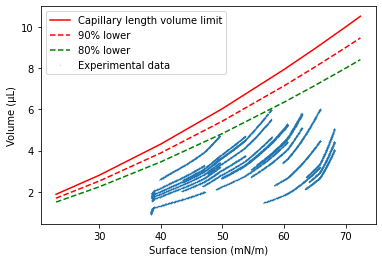

### Drop data

In [ ]:
dataset=dataset.drop(labels=test_data_drop.index, axis=0)

Text(0, 0.5, 'Surface tension (mN/m)')

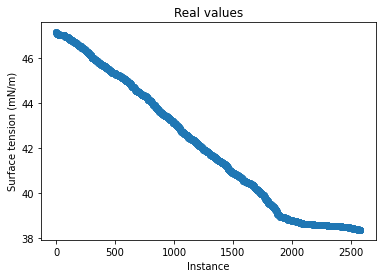

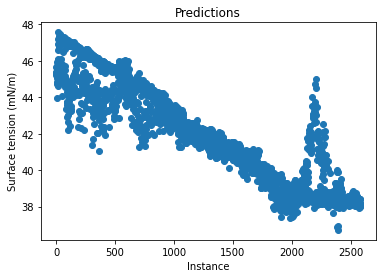

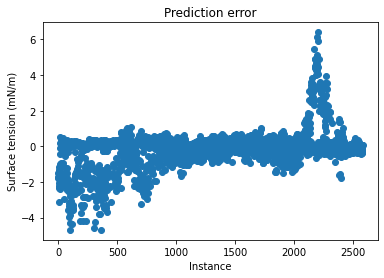

In [813]:

check_train_df=pd.DataFrame(data={'Train_true_values': train_labels, 'Train_predictions': train_predictions})

sorted_st=check_train_df.sort_values(by=['Train_true_values'], ascending=False)

plt.figure()
plt.title('Real values')
plt.plot(range(len(sorted_st)), sorted_st.Train_true_values, '-o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Predictions')
plt.plot(range(len(sorted_st)), sorted_st.Train_predictions, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Prediction error')
plt.plot(range(len(sorted_st)), sorted_st.Train_predictions-sorted_st.Train_true_values, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

# sorted_st

In [824]:
sorted_st['Train_error']= sorted_st.Train_predictions-sorted_st.Train_true_values
train_data_drop=sorted_st.loc[(sorted_st['Train_error'] >= 1) | (sorted_st['Train_error']<=-1)]
print(train_data_drop.shape)
min(train_data_drop.head(100).Train_true_values)

(420, 3)


46.383801395040685

In [ ]:
dataset=dataset.drop(labels=train_data_drop.index, axis=0)


In [ ]:
dataset=dataset.reset_index()
dataset.pop('index')
dataset.tail()

,rho_1,rho_3,rho_5,rho_7,rho_9,rho_11,rho_13,rho_15,rho_17,rho_19,rho_21,rho_23,rho_25,rho_27,rho_29,rho_31,rho_33,rho_35,rho_37,rho_39,rho_41,rho_43,rho_45,rho_47,rho_49,rho_51,rho_53,rho_55,rho_57,rho_59,rho_61,rho_63,rho_65,rho_67,rho_69,rho_71,rho_73,rho_75,rho_77,rho_79,...,theta_263,theta_264,theta_265,theta_266,theta_267,theta_268,theta_269,theta_270,theta_271,theta_272,theta_273,theta_274,theta_275,theta_276,theta_277,theta_278,theta_279,theta_280,theta_281,theta_282,theta_283,theta_284,theta_285,theta_286,theta_287,theta_288,theta_289,theta_290,theta_291,theta_292,theta_293,theta_294,theta_295,theta_296,theta_297,theta_298,theta_299,volume,volt,ST
5849,0.844852,0.845890,0.841633,0.842615,0.836769,0.830557,0.827929,0.824635,0.824272,0.821471,0.817383,0.804511,0.799293,0.781833,0.761491,0.742671,0.728801,0.723573,0.721234,0.712572,0.710763,0.706064,0.701773,0.695164,0.690900,0.687504,0.686343,0.682945,0.683406,0.682506,0.680832,0.681154,0.682249,0.683085,0.684112,0.683459,0.683213,0.686737,0.687046,0.688886,...,-0.663594,-0.686655,-0.698097,-0.716860,-0.728159,-0.776258,-0.834008,-0.866013,-0.880265,-0.935770,-0.949680,-1.058275,-1.064875,-1.082262,-1.088792,-1.095296,-1.108222,-1.125348,-1.153057,-1.203453,-1.226036,-1.323012,-1.332004,-1.337588,-1.342090,-1.362115,-1.376555,-1.399983,-1.405271,-1.424053,-1.437640,-1.442765,-1.493502,-1.543592,-1.552658,-1.561726,-1.566261,2.027260,7.43,39.977682
5850,0.843875,0.844343,0.844776,0.842817,0.840418,0.839495,0.833654,0.826622,0.821420,0.819655,0.813600,0.811674,0.811656,0.794127,0.787912,0.769482,0.750131,0.734104,0.719002,0.714778,0.710755,0.704677,0.704241,0.700826,0.695588,0.688909,0.689376,0.685354,0.682209,0.680340,0.682873,0.682745,0.680340,0.682209,0.681050,0.682659,0.684457,0.685631,0.686953,0.688038,...,-0.703795,-0.707777,-0.715144,-0.726426,-0.730307,-0.756103,-0.767152,-0.785398,-0.796267,-0.846473,-0.909753,-0.940721,-0.954584,-1.011938,-1.022827,-1.129557,-1.133880,-1.150877,-1.157160,-1.163412,-1.173999,-1.190729,-1.217806,-1.265269,-1.285794,-1.378811,-1.388687,-1.393200,-1.397720,-1.417279,-1.430840,-1.454088,-1.459135,-1.477249,-1.491238,-1.495767,-1.545858,2.030530,7.43,40.001022
5851,0.805794,0.806557,0.804432,0.803940,0.800494,0.800165,0.796757,0.792245,0.772310,0.763105,0.758374,0.754836,0.722453,0.714430,0.707578,0.687996,0.679630,0.676913,0.669677,0.661611,0.660593,0.655569,0.649853,0.649921,0.646762,0.644269,0.644564,0.640740,0.641310,0.641926,0.643064,0.644859,0.645856,0.647418,0.647982,0.649538,0.653401,0.653848,0.658930,0.662848,...,-0.913003,-0.938330,-0.945666,-0.960285,-0.963273,-0.977747,-1.006445,-1.013564,-1.074093,-1.144169,-1.150794,-1.210003,-1.214631,-1.225613,-1.231913,-1.238177,-1.253704,-1.259881,-1.275355,-1.302840,-1.328754,-1.343997,-1.348714,-1.404464,-1.424157,-1.428899,-1.458560,-1.468042,-1.477542,-1.482719,-1.496945,-1.511201,-1.539927,-1.549422,-1.554171,-1.558920,-1.568421,1.741854,8.45,38.573873
5852,0.807705,0.808466,0.806337,0.805828,0.798625,0.798304,0.794916,0.790431,0.767185,0.758121,0.753505,0.750031,0.715655,0.704924,0.700928,0.681605,0.670133,0.667453,0.663695,0.652378,0.651458,0.646499,0.644731,0.641182,0.638243,0.635855,0.636349,0.633203,0.633954,0.634680,0.636751,0.638243,0.638747,0.642037,0.640097,0.641968,0.645525,0.648938,0.649592,0.652659,...,-0.914618,-0.939880,-0.947198,-0.961782,-0.964758,-0.979197,-1.007824,-1.014926,-1.075305,-1.147261,-1.151812,-1.210873,-1.215491,-1.228102,-1.232730,-1.238976,-1.255985,-1.260628,-1.277478,-1.303482,-1.329333,-1.344540,-1.350303,-1.404861,-1.424506,-1.429909,-1.458826,-1.468286,-1.478205,-1.482928,-1.497120,-1.511624,-1.540000,-1.549473,-1.554210,-1.558949,-1.568427,1.733268,8.61,38.568306
5853,0.807560,0.808248,0.806010,0.805229,0.801560,0.801149,0.797571,0.789227,0.772317,0.762892,0.754737,0.751152,0.718440,0.707544,0.700562,0.680607,0.668767,0.665928,0.661984,0.653801,0.649152,0.647708,0.641968,0.638312,0.635130,0.632637,0.632949,0.629205,0.629380,0.629937,0.631468

### Save dataset

In [825]:
path=str('/content/drive/MyDrive/DropLev/Levitator_2/Training/CTAB/Clean_files/')
csvfilename='meh_CTAB14_clean_drops_1_3.csv'

dataset.to_csv(path+csvfilename, sep=';', header=True)


### Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the model in a **SavedModel** format

In [133]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [134]:
import os

In [135]:
# Save the entire model as a SavedModel.
folder=str('Clean/')
filename=str('CTAB_files_9_and_15_0.16.h5')
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

### Try out a different model

In [ ]:
def build_model():
  model = keras.Sequential([
    layers.Dense(200, activation=tf.nn.softplus, input_shape=[len(normed_train_data.keys())]),
    layers.Dense(100, activation=tf.nn.swish), # input_shape=[len(normed_train_data.keys())]),
    layers.Dense(50, activation=tf.nn.softplus),
    layers.Dense(5, activation=tf.nn.swish),
    layers.Dense(1)
  ])

  optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
model_big = build_model()

### If there is a model saved on google drive execute the next block

In [ ]:
from tensorflow.keras.models import load_model

del model 

model_name=str('test_training_whole_drop_3μL_best_175points_noise_0.004_vol_6.h5')
model = load_model(str("/content/drive/My Drive/DropLev/MachineLearningModels/"+model_name))


#### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
model_big.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 200)               70200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 95,611
Trainable params: 95,611
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = normed_train_data[:10]
example_result = model_big.predict(example_batch)
example_result

array([[0.4646791 ],
       [0.46449545],
       [0.44632238],
       [0.4460677 ],
       [0.4428678 ],
       [0.46233898],
       [0.44848484],
       [0.48535466],
       [0.44410846],
       [0.50217676]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

#### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=75, min_delta=0)

history_big = model_big.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])



....................................................................................................
.............................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist_big = pd.DataFrame(history_big.history)
hist_big['epoch'] = history_big.epoch
hist_big.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
124,109.842056,8.555373,109.842056,110.820740,8.603889,110.820740,124
125,109.929482,8.557758,109.929482,111.271721,8.649287,111.271721,125
126,109.859123,8.554682,109.859123,111.351135,8.592625,111.351135,126
127,109.711716,8.549767,109.711716,111.419083,8.663173,111.419083,127
128,109.710609,8.545816,109.710609,111.692207,8.661056,111.692207,128


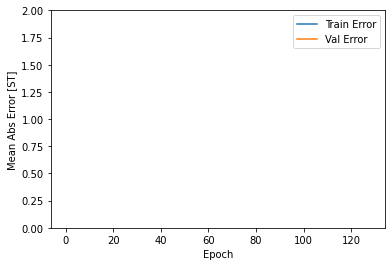

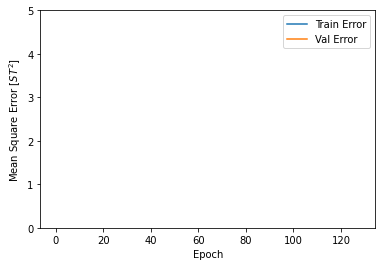

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history_big)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = model_big.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  8.67 mN/m


#### Make predictions

Finally, predict ST values using data in the testing set:

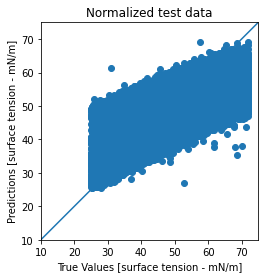

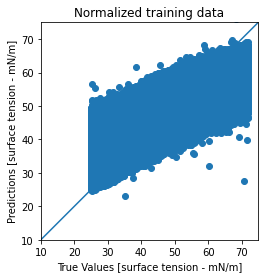

In [ ]:
test_predictions_big = model_big.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions_big)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2_big = model_big.predict(normed_train_data).flatten()

plt.scatter(train_labels, test_predictions2_big)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

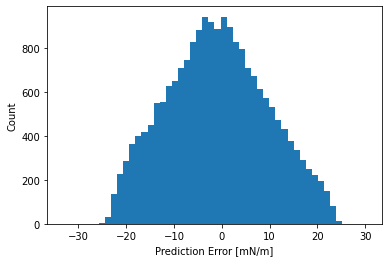

In [ ]:
error_big = test_predictions_big - test_labels
plt.hist(error_big, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 5)
plt.show()

#### Trying model No 3


In [ ]:
# def build_model():
#   model = keras.Sequential([
#     #layers.Dense(100, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
#     layers.Conv3D(64, kernel_size=(5,5, 5), strides=(1, 1, 1), activation=tf.nn.swish, input_shape=[len(normed_train_data.keys())]),
#     layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1)),
#     layers.Conv3D(32, kernel_size=(5, 5, 5), strides=(1, 1, 1), activation=tf.nn.swish),
#     layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(1, 1, 1)),
#     layers.Flatten(),
#     layers.Dense(14, activation=tf.nn.swish),
#     layers.Dense(5, activation=tf.nn.swish),
#     layers.Dense(1)
#   ])

#   optimizer = get_optimizer() # tf.keras.optimizers.Adam(learning_rate=0.001) #RMSprop(0.0001)
#   model.compile(loss='mean_squared_error',
#                 optimizer=optimizer,
#                 metrics=['mean_absolute_error', 'mean_squared_error'])
#   return model

#### Reshape the data

In [ ]:
print(normed_train_data.shape)

(80000, 350)


In [ ]:
sample_size = normed_train_data.shape[0] # number of samples in train set
time_steps1  =2 # int(normed_train_data.shape[1]) # number of features in train set
time_steps2 =175 #int(normed_train_data.shape[1]/25)
input_dimension = 1               # each feature is represented by 1 number

train_data_reshaped = normed_train_data.values.reshape(sample_size, time_steps1, time_steps2, input_dimension)

input_shape=train_data_reshaped.shape
print(input_shape)

(80000, 2, 175, 1)


#### Reshape test data

In [ ]:
test_data_reshaped = normed_test_data.values.reshape(normed_test_data.shape[0], 2, 175, 1) #int(normed_test_data.shape[1]/25)

In [ ]:
def build_model():
  
  n_timesteps = train_data_reshaped.shape[1] #Number of features
  n_features  = train_data_reshaped.shape[2] #Number of output(s)
  dimension=1
  model = keras.Sequential([
    # layers.Input(shape=),
    layers.Conv2D(filters=50, kernel_size=(1, 1), activation="relu", input_shape=(n_timesteps,n_features, dimension)),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),
    layers.Conv2D(filters=25, kernel_size=(1, 1), activation="relu"),
    layers.MaxPooling2D(pool_size=(1, 1)),
    layers.BatchNormalization(),
    # layers.GlobalAveragePooling3D(),
    layers.Flatten(),
    # layers.Dense(100, activation=tf.nn.softplus),
    # layers.Dense(50, activation=tf.nn.swish),
    layers.Dense(10, activation=tf.nn.softplus),
    layers.Dense(1)
  ])

 # optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mean_squared_error',
                optimizer=get_optimizer(),
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [ ]:
CNN_model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [ ]:
CNN_model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 2, 175, 50)        100       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 2, 175, 50)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 2, 175, 50)        200       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 2, 175, 25)        1275      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 2, 175, 25)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 2, 175, 25)        100       
_________________________________________________________________
flatten_13 (Flatten)         (None, 8750)            


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [ ]:
example_batch = train_data_reshaped[:10]
example_result = CNN_model.predict(example_batch)
example_result

array([[28.087883],
       [32.96527 ],
       [44.103367],
       [69.42511 ],
       [51.100143],
       [45.80421 ],
       [56.901924],
       [51.55749 ],
       [65.29247 ],
       [46.492516]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [ ]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=15, verbose=0, mode='auto')

history_CNN = CNN_model.fit(train_data_reshaped, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])  # callbacks=callbacks_list



.............................

Visualize the model's training progress using the stats stored in the `history` object.

In [ ]:
hist_CNN = pd.DataFrame(history_CNN.history)
hist_CNN['epoch'] = history_CNN.epoch
hist_CNN.tail() 

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
24,111.828896,8.636181,111.828896,109.931259,8.527595,109.931259,24
25,111.635277,8.627120,111.635277,113.665749,8.749763,113.665749,25
26,111.584976,8.627238,111.584976,110.240440,8.568928,110.240440,26
27,111.479774,8.623121,111.479774,110.773445,8.627024,110.773445,27
28,111.552353,8.625348,111.552353,109.793175,8.562902,109.793175,28


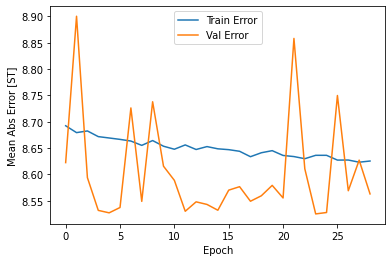

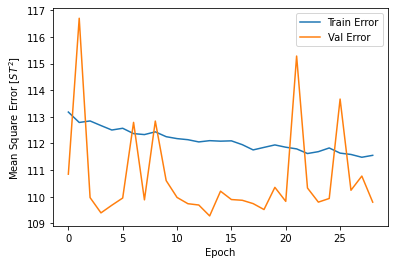

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ST]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  # plt.ylim([0,2])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ST^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  # plt.ylim([0,5])
  plt.legend()
  plt.show()


plot_history(history_CNN)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [ ]:
loss, mae, mse = CNN_model.evaluate(test_data_reshaped, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  8.74 mN/m


### Make predictions

Finally, predict ST values using data in the testing set:

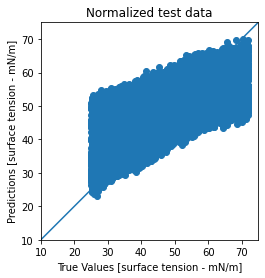

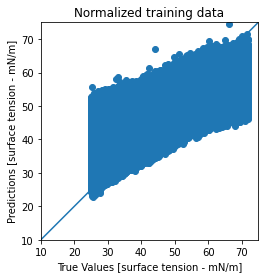

In [ ]:
test_predictions_CNN = CNN_model.predict(test_data_reshaped).flatten()

plt.scatter(test_labels, test_predictions_CNN)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

test_predictions2_CNN = CNN_model.predict(train_data_reshaped).flatten()

plt.scatter(train_labels, test_predictions2_CNN)
plt.title('Normalized training data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

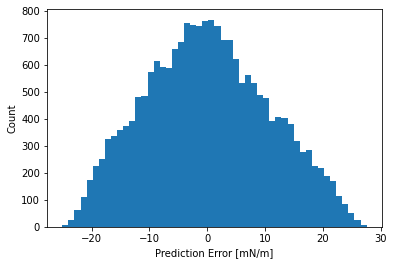

In [ ]:
error_CNN = test_predictions_CNN - test_labels
plt.hist(error_CNN, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
#plt.ylim(0, 5)
plt.show()

### Saving the final Model

When you are satisfied with the model and the accuracy continue from here:

Run the next code box only if google drive is not mounted to colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Saving the model in a **SavedModel** format

In [ ]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

In [ ]:
import os

In [ ]:
# Save the entire model as a SavedModel.
folder=str('theoretical_all_vary/')
filename=str('CNN_model_all_vary_with_Ps_noise_Ps_1300_2800_2_6μL_30_70mN_m_no_noise_only_contours_1.h5')
#!mkdir -p '/content/drive/My Drive/DropLev/MachineLearningModels' #Ceates a folder named "MachineLearningModels"
CNN_model.save('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)  #Saves the file

### Reload a fresh Keras model from the saved model:

For **SavedModel** format

In [190]:
folder=str('Experimental_surfactants/')
filename=str('CTAB_files_7_14_0.37.h5')

del model

model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+folder+filename)

# Check its architecture
model.summary()

Model: "sequential_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 40)                14120     
_________________________________________________________________
dense_118 (Dense)            (None, 20)                820       
_________________________________________________________________
dense_119 (Dense)            (None, 1)                 21        
Total params: 14,961
Trainable params: 14,961
Non-trainable params: 0
_________________________________________________________________


View the MAE of the saved and re-called model:

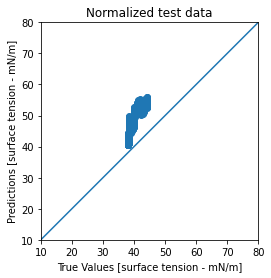

In [191]:

labels=normed_data.pop('ST')

predictions = model.predict(normed_data).flatten()

plt.scatter(labels, predictions)
plt.title('Normalized test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,80])
plt.ylim([10,80])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()




In [192]:
# Evaluation
loss, mae, mse = model.evaluate(normed_data, labels, verbose=0)
print('Restored model, Mean absolute error: {:5.2f}'.format(mae))


Restored model, Mean absolute error:  7.82


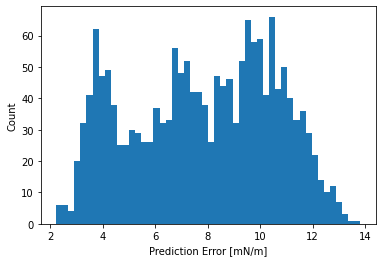

In [193]:
error = predictions - labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
# plt.xlim(-3.5, 3.5)
# plt.ylim(0, 10)
plt.show()

Text(0, 0.5, 'Surface tension (mN/m)')

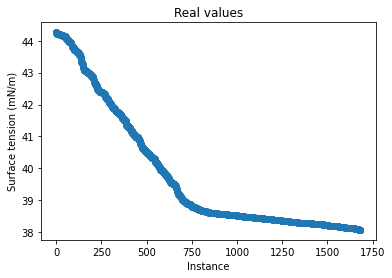

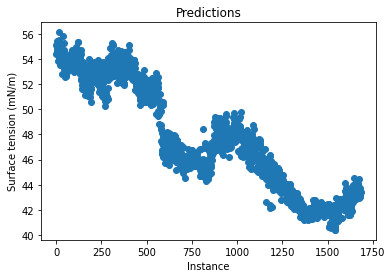

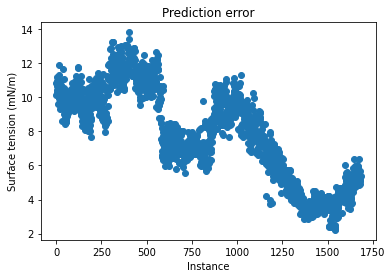

In [261]:

check_df=pd.DataFrame(data={'True_values': labels, 'Predictions': predictions})

sorted_st=check_df.sort_values(by=['True_values'], ascending=False)

plt.figure()
plt.title('Real values')
plt.plot(range(len(sorted_st)), sorted_st.True_values, '-o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Predictions')
plt.plot(range(len(sorted_st)), sorted_st.Predictions, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

plt.figure()
plt.title('Prediction error')
plt.plot(range(len(sorted_st)), sorted_st.Predictions-sorted_st.True_values, 'o')
plt.xlabel('Instance')
plt.ylabel('Surface tension (mN/m)')

# sorted_st

In [155]:
sorted_st['error']= sorted_st.Predictions-sorted_st.True_values
data_drop=sorted_st.loc[(sorted_st['error'] >= 1) | (sorted_st['error']<=-1)]

print(data_drop.shape)
data_drop


(295, 3)


,True_values,Predictions,error
1367,38.358543,41.540779,3.182236
1368,38.357835,41.342422,2.984587
1366,38.355920,41.492756,3.136836
1369,38.352855,41.627117,3.274262
1375,38.351667,41.568924,3.217256
...,...,...,...
1632,38.166404,43.768383,5.601979
1629,38.165496,43.702946,5.537450
1630,38.163330,44.234226,6.070897
1637,38.161681,43.975159,5.813477


In [137]:
normed_data['ST']=labels

normed_data=normed_data.drop(labels=data_drop.index, axis=0)

### Genarate new data and evaluate the saved model

In [ ]:
def norm_test(x):
  return (x - stats_input_df['mean']) / stats_input_df['std']

#import model from drive
#filename=str('test_training_whole_drop_best.h5')
#model = tf.keras.models.load_model('/content/drive/My Drive/DropLev/MachineLearningModels/'+filename)


num_sample_test=25
sampling=175
vol_drop=np.random.random(num_sample_test)*(7-2)+2
R_sph=calc_R_sph(vol_drop[i], calibration)
Ps=np.random.random(num_sample_test)*(2000-1000)+2000 #Pa
theta_test=np.random.rand(num_sample_test, sampling)*np.pi*2
theta_test.sort()

ST_test=np.random.random(num_sample_test)*(72-25)+25

r_all_test=np.empty([0,sampling])

for i in range(num_sample_test):
  r_test=R_predict(theta_test[i], ST_test[i], R_sph[i], Ps[i], Cg_air, k_o)
  r_all_test=np.vstack((r_all_test, r_test))

test_dataset=np.hstack((theta_test,r_all_test, ST_test.reshape([num_sample_test,1])))

############### Adding noise #############################
noise = np.random.random(size=test_dataset.shape)*0.1
#print(noise)
test_dataset=test_dataset+noise
plt.figure()
plt.plot(test_dataset[0, 0:sampling], test_dataset[0, sampling:sampling*2])
##########################################################

input_array=test_dataset[:, 0:sampling*2]
input_df=pd.DataFrame(input_array, index=None, dtype=float)

stats_input_df=input_df.describe()
stats_input_df=stats_input_df.transpose()

norm_input_array=norm_test(input_df)
prediction=model.predict(norm_input_array).flatten()
true_values=test_dataset[:, sampling*2]

plt.figure()
plt.xlabel('Frame number')
plt.ylabel('Surface tension [ mN/m ]')
plt.ylim(20, 75)
plt.plot(prediction, label='Predicted values')
plt.plot(true_values, label='Real values')
plt.legend()

plt.figure()
plt.scatter(true_values, prediction)
plt.title('Normalized new test data')
plt.xlabel('True Values [surface tension - mN/m]')
plt.ylabel('Predictions [surface tension - mN/m]')
plt.axis('equal')
plt.axis('square')
plt.xlim([10,75])
plt.ylim([10,75])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()

error = prediction - true_values
plt.figure()
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [mN/m]")
_ = plt.ylabel("Count")
plt.show()


### CMC determination through regression


Text(0, 0.5, 'Surface tension (mN/m)')

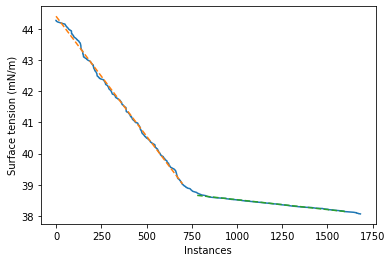

In [334]:
from scipy.stats import linregress


normed_data.sort_values(by=['ST'], ascending=False, inplace=True)

x1=range(0, 700)
y1=normed_data.ST[0:700]

x2=range(780, 1600)
y2=normed_data.ST[780:1600]

slope1, intercept1, r1, p1, se1 = linregress(x1, y1)
slope2, intercept2, r2, p2, se2 = linregress(x2, y2)



plt.figure()
plt.plot(range(len(normed_data)), normed_data.ST)
plt.plot(range(0, 700), slope1*range(0, 700)+intercept1, '--')
plt.plot(range(780, 1600), slope2*range(780, 1600)+intercept2, '--')
plt.xlabel('Instances')
plt.ylabel('Surface tension (mN/m)')

In [332]:
#Solution: Cross point of lines

cross_point=(intercept2-intercept1)/(slope1-slope2)

print(cross_point) #corresponds to CMC if x-axis is concentration

744.0683144587553


In [ ]:
# # conc=range(0, len(sorted_st))
# plt.figure()
# plt.plot(sorted_st.ST)

In [249]:
# #Rotation matrix
# theta=np.pi/2
# R=np.array([[np.cos(theta), -np.sin(theta)],
#             [ np.sin(theta), np.cos(theta)]])


In [ ]:
# rotation_df=np.array([conc, sorted_st.True_values])

# rotation_df.shape

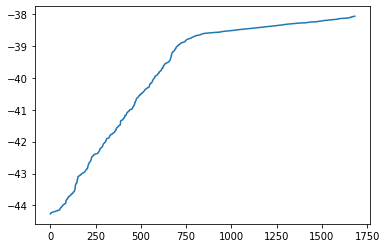

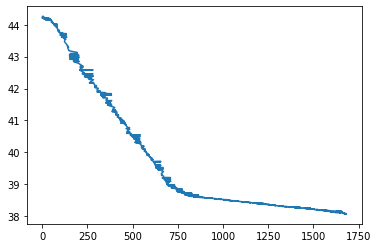

In [251]:
# rotated=R.dot(rotation_df)

# plt.figure()
# # plt.plot(sorted_st.True_values)
# plt.plot(rotated[1, :], rotated[0, :])

# plt.figure()
# plt.plot(sorted_st.True_values)